In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

pi = torch.tensor(np.pi,dtype=torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)

class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1


def plot_2D(f): 
    
    Nx = 400
    Ny = 400 
    xs = np.linspace(0, 1, Nx)
    ys = np.linspace(0, 1, Ny)
    x, y = np.meshgrid(xs, ys, indexing='xy')
    xy_comb = np.stack((x.flatten(),y.flatten())).T
    xy_comb = torch.tensor(xy_comb)
    z = f(xy_comb).reshape(Nx,Ny)
    z = z.detach().numpy()
    plt.figure(dpi=200)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x , y , z )

    plt.show()

def plot_subdomains(my_model):
    x_coord =torch.linspace(0,1,200)
    wi = my_model.fc1.weight.data
    bi = my_model.fc1.bias.data 
    for i, bias in enumerate(bi):  
        if wi[i,1] !=0: 
            plt.plot(x_coord, - wi[i,0]/wi[i,1]*x_coord - bias/wi[i,1])
        else: 
            plt.plot(x_coord,  - bias/wi[i,0]*torch.ones(x_coord.size()))

    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.legend()
    plt.show()
    return 0   



/Applications/anaconda3/lib/python3.9/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025540001/work/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [2]:
 
def PiecewiseGQ2D(target, Nx, order): 
    """
    Parameters
    ----------
    target : 
        Target function 
    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature
    """

#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 
    integration_points = integration_points.to(device)
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    func_values = target(integration_points) # .to(device)
#     print("func values size ",func_values.size())

    long_weights = long_weights.to(device)
    integral_value = long_weights.T@func_values # this allows multiple functions, stored in columns
    return integral_value


def PiecewiseGQ2D_weights_points(Nx, order): 
    """ A slight modification of PiecewiseGQ2D function that only needs the weights and integration points.
    Parameters
    ----------

    Nx: int 
        number of intervals along the dimension. No Ny, assume Nx = Ny
    order: int 
        order of the Gauss Quadrature

    Returns
    -------
    long_weights: torch.tensor
    integration_points: torch.tensor
    """

#     print("order: ",order )
    x, w = np.polynomial.legendre.leggauss(order)
    gauss_pts = np.array(np.meshgrid(x,x,indexing='ij')).reshape(2,-1).T
    weights =  (w*w[:,None]).ravel()

    gauss_pts =torch.tensor(gauss_pts)
    weights = torch.tensor(weights)

    h = 1/Nx # 100 intervals 
    long_weights =  torch.tile(weights,(Nx**2,1))
    long_weights = long_weights.reshape(-1,1)
    long_weights = long_weights * h**2 /4 

    integration_points = torch.tile(gauss_pts,(Nx**2,1))
    scale_factor = h/2 
    integration_points = scale_factor * integration_points

    index = np.arange(1,Nx+1)-0.5
    ordered_pairs = np.array(np.meshgrid(index,index,indexing='ij'))
    ordered_pairs = ordered_pairs.reshape(2,-1).T

    # print(ordered_pairs)
    # print()
    ordered_pairs = torch.tensor(ordered_pairs)
    # print(ordered_pairs.size())
    ordered_pairs = torch.tile(ordered_pairs, (1,order**2)) # number of GQ points
    # print(ordered_pairs)

    ordered_pairs =  ordered_pairs.reshape(-1,2)
    # print(ordered_pairs)
    translation = ordered_pairs*h 
    # print(translation)

    integration_points = integration_points + translation 
#     print(integration_points.size())
    # func_values = integrand2_torch(integration_points)
    return long_weights, integration_points

def minimize_linear_layer(model,target, solver="direct",Nx = 50, order =3):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    def loss_function_inside(x):
        #my_model is a global variable
        return 0.5*torch.pow(model(x)-target(x),2).to(device)

    def rhs_loss_inside(x): 
        # Helper function: differentiate this wrt linear layer parameters give the rhs
        return model(x)*target(x)

    loss = PiecewiseGQ2D(loss_function_inside, Nx,order)
    # Extract the linear system A :  
    du1 = torch.autograd.grad(outputs=loss, inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
    jac = '' # Fix a bug: my_model -> model 2023 Mar. 14th 
    torch.set_printoptions(precision=8)
    neuron_number = model.fc1.bias.size(0)
    for i in range(neuron_number): # Fix a bug: hidden_size1 -> neuron_number 2023 Mar. 14th 
        duui = torch.autograd.grad(outputs=du1[0,i], inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
        if i == 0: # Fix a bug: my_model -> model 2023 Mar. 14th 
            jac = duui
        else: 
            jac = torch.cat([jac,duui],dim=0)

    loss_helper = PiecewiseGQ2D(rhs_loss_inside, Nx, order)
    rhs = torch.autograd.grad(outputs=loss_helper, inputs=model.fc2.weight, retain_graph=True,create_graph = True)[0]
    rhs = rhs.view(-1,1)

    # Solve the linear system using different solvers 
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
#         sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    return sol 

def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 



def OGAL2FittingReLU2D(my_model,target,N_list,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct"): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    # print(func_values_sqrd.size())
    # print(gw_expand.size()) 
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    start_time = time.time()
    solver = linear_solver
    relu_dict_parameters = generate_relu_dict2D(N_list).to(device)
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        print("epoch: ",i+1, end = '\t')
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand  
        basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting

        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        neuron_index = torch.argmax(output.flatten())
        
        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        #Todo Done 
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,gw_expand, integration_points, solver)

        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu())
            my_model = my_model.to(device)

        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values

        #Todo Done 
        err[i+1]= torch.sum(func_values_sqrd*gw_expand)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model


def generate_relu_dict2D(N_list):
    N1 = N_list[0] 
    N2 = N_list[1]
    
    theta = np.linspace(0, 2*pi, N1, endpoint= False).reshape(N1,1)
    W1 = np.cos(theta)
    W2 = np.sin(theta)
    W = np.concatenate((W1,W2),1) # N1 x 2
    b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1)
    
    index1 = np.arange(N1)
    index2 = np.arange(N2)
    ordered_pairs = np.array(np.meshgrid(index1,index2,indexing='ij'))

    ordered_pairs = ordered_pairs.reshape(2,-1).T
    W = W[ordered_pairs[:,0],:]
    b = b[ordered_pairs[:,1],:]
    Wb = np.concatenate((W,b),1) # N1 x 3 
    Wb_tensor = torch.from_numpy(Wb) 
    return Wb_tensor

N_list = [10,20]
Wb = generate_relu_dict2D(N_list).to(device)
print(Wb.shape)


def generate_relu_dict2D_QMC(s,N0):
    # add this method to your notes... otherwise you will forget it 
    # Generate randomized Sobol sequence 
    
#     Sob = torch.quasirandom.SobolEngine(dimension =2, scramble= True, seed=None) 
#     samples = Sob.draw(N0).double()

#     for i in range(s-1):
#         samples = torch.cat([samples,Sob.draw(N0).double()],0)

    samples = torch.rand(s*N0,2) 
    
    T =torch.tensor([[2*pi,0],[0,2.84]])

    shift = torch.tensor([0,-1.42]) 

    samples = samples@T + shift 

    theta = samples[:,0].reshape(s*N0,1)
    W1 = torch.cos(theta)
    W2 = torch.sin(theta)
    W = torch.cat((W1,W2),1) # N1 x 2
    # b = np.linspace(-1.42, 1.42, N2,endpoint=False).reshape(N2,1) 
    b = samples[:,1].reshape(s*N0,1)
    
    Wb = torch.cat((W,b),1) # N1 x 3 

    return Wb 

def OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct"): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """
    #Todo Done
    gw_expand, integration_points = PiecewiseGQ2D_weights_points(Nx, order)
    gw_expand = gw_expand.to(device)
    integration_points = integration_points.to(device)

    err = torch.zeros(num_epochs+1)
    if my_model == None: 
        func_values = target(integration_points)
        num_neuron = 0

        list_b = []
        list_w = []
    else: 
        func_values = target(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))

        list_b = list(bias)
        list_w = list(weights)
    
    # initial error Todo Done
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*gw_expand)**0.5
    start_time = time.time()
    
    solver = linear_solver
    print("using linear solver: ",solver)
    for i in range(num_epochs): 
        relu_dict_parameters = generate_relu_dict2D_QMC(s,N0).to(device) 
        print("epoch: ",i+1, end = '\t')
        if num_neuron == 0: 
            func_values = target(integration_points)
        else: 
            func_values = target(integration_points) - my_model(integration_points).detach()

        weight_func_values = func_values*gw_expand  
        basis_values = (F.relu( torch.matmul(integration_points,relu_dict_parameters[:,0:2].T ) - relu_dict_parameters[:,2])**k).T # uses broadcasting

        output = torch.abs(torch.matmul(basis_values,weight_func_values)) # 
        neuron_index = torch.argmax(output.flatten())
        
        # print(neuron_index)
        list_w.append(relu_dict_parameters[neuron_index,0:2]) # 
        list_b.append(-relu_dict_parameters[neuron_index,2])
        num_neuron += 1
        my_model = model(2,num_neuron,1,k).to(device)
        w_tensor = torch.stack(list_w, 0 ) 
        b_tensor = torch.tensor(list_b)
        my_model.fc1.weight.data[:,:] = w_tensor[:,:]
        my_model.fc1.bias.data[:] = b_tensor[:]

        #Todo 
#         sol = minimize_linear_layer(my_model,target,solver,Nx,order)
        sol = minimize_linear_layer_explicit_assemble(my_model,target,gw_expand, integration_points, solver)

        my_model.fc2.weight.data[0,:] = sol[:]
        if (i+1)%plot_freq == 0: 
            plot_2D(my_model.cpu())
            my_model = my_model.to(device)

        func_values = target(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values

        #Todo Done 
        err[i+1]= torch.sum(func_values_sqrd*gw_expand)**0.5
    print("time taken: ",time.time() - start_time)
    return err, my_model


torch.Size([200, 3])


In the following tests, we compare using deterministic dictionaries with using random dictionary for the following three target functions. 

- $\sin(\pi x_1) \sin(\pi x_2)$ 
- $\sin(4\pi x_1) \sin(8\pi x_2)$ 
- Gabor function 

## Gabor function  deterministic 

using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.00034308433532714844
solving Ax = b time taken:  0.0001838207244873047
epoch:  2	assembling the matrix time taken:  0.0003097057342529297
solving Ax = b time taken:  0.00016808509826660156
epoch:  3	assembling the matrix time taken:  0.00028896331787109375
solving Ax = b time taken:  0.00016355514526367188
epoch:  4	assembling the matrix time taken:  0.0002834796905517578
solving Ax = b time taken:  0.00015473365783691406
epoch:  5	assembling the matrix time taken:  0.00030612945556640625
solving Ax = b time taken:  0.00015306472778320312
epoch:  6	assembling the matrix time taken:  0.0002837181091308594
solving Ax = b time taken:  0.0001628398895263672
epoch:  7	assembling the matrix time taken:  0.00028228759765625
solving Ax = b time taken:  0.00016188621520996094
epoch:  8	assembling the matrix time taken:  0.0002799034118652344
solving Ax = b time taken:  0.0001614093780517578
epoch:  9	assembling the matrix t

epoch:  84	assembling the matrix time taken:  0.0003399848937988281
solving Ax = b time taken:  0.0010781288146972656
epoch:  85	assembling the matrix time taken:  0.0003428459167480469
solving Ax = b time taken:  0.0011615753173828125
epoch:  86	assembling the matrix time taken:  0.00034165382385253906
solving Ax = b time taken:  0.0011539459228515625
epoch:  87	assembling the matrix time taken:  0.0003509521484375
solving Ax = b time taken:  0.0011587142944335938
epoch:  88	assembling the matrix time taken:  0.00035381317138671875
solving Ax = b time taken:  0.0011436939239501953
epoch:  89	assembling the matrix time taken:  0.0003497600555419922
solving Ax = b time taken:  0.0012090206146240234
epoch:  90	assembling the matrix time taken:  0.0003540515899658203
solving Ax = b time taken:  0.001177072525024414
epoch:  91	assembling the matrix time taken:  0.0003523826599121094
solving Ax = b time taken:  0.0012106895446777344
epoch:  92	assembling the matrix time taken:  0.0003404617

epoch:  163	assembling the matrix time taken:  0.0003714561462402344
solving Ax = b time taken:  0.003517627716064453
epoch:  164	assembling the matrix time taken:  0.0003695487976074219
solving Ax = b time taken:  0.0034165382385253906
epoch:  165	assembling the matrix time taken:  0.0003685951232910156
solving Ax = b time taken:  0.0036101341247558594
epoch:  166	assembling the matrix time taken:  0.0003578662872314453
solving Ax = b time taken:  0.0037529468536376953
epoch:  167	assembling the matrix time taken:  0.00038123130798339844
solving Ax = b time taken:  0.003568410873413086
epoch:  168	assembling the matrix time taken:  0.00034165382385253906
solving Ax = b time taken:  0.0035240650177001953
epoch:  169	assembling the matrix time taken:  0.0003552436828613281
solving Ax = b time taken:  0.0035181045532226562
epoch:  170	assembling the matrix time taken:  0.00032830238342285156
solving Ax = b time taken:  0.0036420822143554688
epoch:  171	assembling the matrix time taken:  

solving Ax = b time taken:  0.00746464729309082
epoch:  236	assembling the matrix time taken:  0.00033926963806152344
solving Ax = b time taken:  0.0060880184173583984
epoch:  237	assembling the matrix time taken:  0.0003752708435058594
solving Ax = b time taken:  0.006148576736450195
epoch:  238	assembling the matrix time taken:  0.0003345012664794922
solving Ax = b time taken:  0.0061876773834228516
epoch:  239	assembling the matrix time taken:  0.0003311634063720703
solving Ax = b time taken:  0.006292819976806641
epoch:  240	assembling the matrix time taken:  0.0003352165222167969
solving Ax = b time taken:  0.00597381591796875
epoch:  241	assembling the matrix time taken:  0.0003428459167480469
solving Ax = b time taken:  0.006281375885009766
epoch:  242	assembling the matrix time taken:  0.00036263465881347656
solving Ax = b time taken:  0.006284236907958984
epoch:  243	assembling the matrix time taken:  0.00033473968505859375
solving Ax = b time taken:  0.006470203399658203
epoc

epoch:  305	assembling the matrix time taken:  0.00038242340087890625
solving Ax = b time taken:  0.008219480514526367
epoch:  306	assembling the matrix time taken:  0.0003364086151123047
solving Ax = b time taken:  0.008332014083862305
epoch:  307	assembling the matrix time taken:  0.00033354759216308594
solving Ax = b time taken:  0.008363485336303711
epoch:  308	assembling the matrix time taken:  0.00034499168395996094
solving Ax = b time taken:  0.008258819580078125
epoch:  309	assembling the matrix time taken:  0.0003845691680908203
solving Ax = b time taken:  0.008333921432495117
epoch:  310	assembling the matrix time taken:  0.0003712177276611328
solving Ax = b time taken:  0.008547067642211914
epoch:  311	assembling the matrix time taken:  0.0003342628479003906
solving Ax = b time taken:  0.008713960647583008
epoch:  312	assembling the matrix time taken:  0.00034689903259277344
solving Ax = b time taken:  0.008330345153808594
epoch:  313	assembling the matrix time taken:  0.000

epoch:  384	assembling the matrix time taken:  0.00036525726318359375
solving Ax = b time taken:  0.01077890396118164
epoch:  385	assembling the matrix time taken:  0.00034689903259277344
solving Ax = b time taken:  0.011571407318115234
epoch:  386	assembling the matrix time taken:  0.00037217140197753906
solving Ax = b time taken:  0.01163625717163086
epoch:  387	assembling the matrix time taken:  0.00038552284240722656
solving Ax = b time taken:  0.011529207229614258
epoch:  388	assembling the matrix time taken:  0.0003707408905029297
solving Ax = b time taken:  0.01172018051147461
epoch:  389	assembling the matrix time taken:  0.0003705024719238281
solving Ax = b time taken:  0.011786222457885742
epoch:  390	assembling the matrix time taken:  0.0003387928009033203
solving Ax = b time taken:  0.011940717697143555
epoch:  391	assembling the matrix time taken:  0.00034809112548828125
solving Ax = b time taken:  0.01201486587524414
epoch:  392	assembling the matrix time taken:  0.000340

epoch:  458	assembling the matrix time taken:  0.0003743171691894531
solving Ax = b time taken:  0.01429605484008789
epoch:  459	assembling the matrix time taken:  0.0003345012664794922
solving Ax = b time taken:  0.014930963516235352
epoch:  460	assembling the matrix time taken:  0.0003383159637451172
solving Ax = b time taken:  0.014311075210571289
epoch:  461	assembling the matrix time taken:  0.0003643035888671875
solving Ax = b time taken:  0.014837026596069336
epoch:  462	assembling the matrix time taken:  0.0003733634948730469
solving Ax = b time taken:  0.014518022537231445
epoch:  463	assembling the matrix time taken:  0.0003330707550048828
solving Ax = b time taken:  0.015005350112915039
epoch:  464	assembling the matrix time taken:  0.00033020973205566406
solving Ax = b time taken:  0.014344453811645508
epoch:  465	assembling the matrix time taken:  0.0003781318664550781
solving Ax = b time taken:  0.015073299407958984
epoch:  466	assembling the matrix time taken:  0.0003714

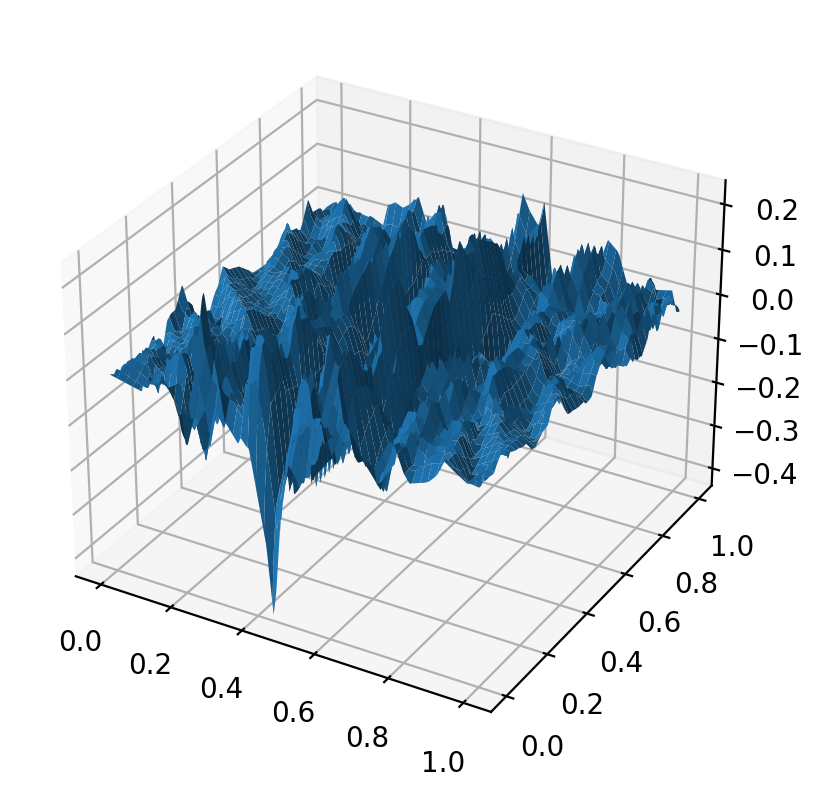

time taken:  7.905987739562988
neuron num 		 error 		 order
4		tensor(0.18782543)		*
8		tensor(0.18588026)		tensor(0.01501882)
16		tensor(0.18546145)		tensor(0.00325426)
32		tensor(0.18362713)		tensor(0.01434005)
64		tensor(0.18121321)		tensor(0.01909111)
128		tensor(0.18035061)		tensor(0.00688383)
256		tensor(0.18022704)		tensor(0.00098886)
512		tensor(0.18022704)		tensor(0.)
using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.0002994537353515625
solving Ax = b time taken:  0.00016069412231445312
epoch:  2	assembling the matrix time taken:  0.0002944469451904297
solving Ax = b time taken:  0.00014495849609375
epoch:  3	assembling the matrix time taken:  0.0002815723419189453
solving Ax = b time taken:  0.00014829635620117188
epoch:  4	assembling the matrix time taken:  0.00027751922607421875
solving Ax = b time taken:  0.00014281272888183594
epoch:  5	assembling the matrix time taken:  0.0002779960632324219
solving Ax = b time taken:  0.00014257431030273438
epoch: 

epoch:  74	assembling the matrix time taken:  0.0003371238708496094
solving Ax = b time taken:  0.0008764266967773438
epoch:  75	assembling the matrix time taken:  0.0003421306610107422
solving Ax = b time taken:  0.0009367465972900391
epoch:  76	assembling the matrix time taken:  0.0003123283386230469
solving Ax = b time taken:  0.0009024143218994141
epoch:  77	assembling the matrix time taken:  0.0003037452697753906
solving Ax = b time taken:  0.0009317398071289062
epoch:  78	assembling the matrix time taken:  0.0003056526184082031
solving Ax = b time taken:  0.0009417533874511719
epoch:  79	assembling the matrix time taken:  0.00037789344787597656
solving Ax = b time taken:  0.0008792877197265625
epoch:  80	assembling the matrix time taken:  0.0003170967102050781
solving Ax = b time taken:  0.0010044574737548828
epoch:  81	assembling the matrix time taken:  0.00033473968505859375
solving Ax = b time taken:  0.001132965087890625
epoch:  82	assembling the matrix time taken:  0.0003027

epoch:  151	assembling the matrix time taken:  0.0003707408905029297
solving Ax = b time taken:  0.0030405521392822266
epoch:  152	assembling the matrix time taken:  0.0003612041473388672
solving Ax = b time taken:  0.003009319305419922
epoch:  153	assembling the matrix time taken:  0.00036263465881347656
solving Ax = b time taken:  0.0031371116638183594
epoch:  154	assembling the matrix time taken:  0.0003619194030761719
solving Ax = b time taken:  0.0031223297119140625
epoch:  155	assembling the matrix time taken:  0.0003705024719238281
solving Ax = b time taken:  0.0032181739807128906
epoch:  156	assembling the matrix time taken:  0.0003674030303955078
solving Ax = b time taken:  0.0031244754791259766
epoch:  157	assembling the matrix time taken:  0.0003600120544433594
solving Ax = b time taken:  0.0032417774200439453
epoch:  158	assembling the matrix time taken:  0.0003390312194824219
solving Ax = b time taken:  0.0032706260681152344
epoch:  159	assembling the matrix time taken:  0

solving Ax = b time taken:  0.005483388900756836
epoch:  224	assembling the matrix time taken:  0.0003657341003417969
solving Ax = b time taken:  0.005465507507324219
epoch:  225	assembling the matrix time taken:  0.00032830238342285156
solving Ax = b time taken:  0.0056400299072265625
epoch:  226	assembling the matrix time taken:  0.000335693359375
solving Ax = b time taken:  0.005799531936645508
epoch:  227	assembling the matrix time taken:  0.0003361701965332031
solving Ax = b time taken:  0.005784749984741211
epoch:  228	assembling the matrix time taken:  0.0003695487976074219
solving Ax = b time taken:  0.005706071853637695
epoch:  229	assembling the matrix time taken:  0.0003287792205810547
solving Ax = b time taken:  0.005992412567138672
epoch:  230	assembling the matrix time taken:  0.00033926963806152344
solving Ax = b time taken:  0.00583338737487793
epoch:  231	assembling the matrix time taken:  0.0003705024719238281
solving Ax = b time taken:  0.005888700485229492
epoch:  2

epoch:  301	assembling the matrix time taken:  0.00036454200744628906
solving Ax = b time taken:  0.009485244750976562
epoch:  302	assembling the matrix time taken:  0.0003616809844970703
solving Ax = b time taken:  0.009452104568481445
epoch:  303	assembling the matrix time taken:  0.00034165382385253906
solving Ax = b time taken:  0.009420633316040039
epoch:  304	assembling the matrix time taken:  0.0003647804260253906
solving Ax = b time taken:  0.009337186813354492
epoch:  305	assembling the matrix time taken:  0.0003387928009033203
solving Ax = b time taken:  0.009707212448120117
epoch:  306	assembling the matrix time taken:  0.0003325939178466797
solving Ax = b time taken:  0.009691476821899414
epoch:  307	assembling the matrix time taken:  0.0003292560577392578
solving Ax = b time taken:  0.00988459587097168
epoch:  308	assembling the matrix time taken:  0.0003666877746582031
solving Ax = b time taken:  0.009752988815307617
epoch:  309	assembling the matrix time taken:  0.000363

solving Ax = b time taken:  0.014438152313232422
epoch:  373	assembling the matrix time taken:  0.0003306865692138672
solving Ax = b time taken:  0.013687610626220703
epoch:  374	assembling the matrix time taken:  0.0003330707550048828
solving Ax = b time taken:  0.013658761978149414
epoch:  375	assembling the matrix time taken:  0.0003361701965332031
solving Ax = b time taken:  0.013843536376953125
epoch:  376	assembling the matrix time taken:  0.0003592967987060547
solving Ax = b time taken:  0.013691425323486328
epoch:  377	assembling the matrix time taken:  0.00035953521728515625
solving Ax = b time taken:  0.014332294464111328
epoch:  378	assembling the matrix time taken:  0.00037980079650878906
solving Ax = b time taken:  0.01376485824584961
epoch:  379	assembling the matrix time taken:  0.0003268718719482422
solving Ax = b time taken:  0.014421701431274414
epoch:  380	assembling the matrix time taken:  0.00036144256591796875
solving Ax = b time taken:  0.01384735107421875
epoch:

solving Ax = b time taken:  0.017905473709106445
epoch:  445	assembling the matrix time taken:  0.0003311634063720703
solving Ax = b time taken:  0.018572092056274414
epoch:  446	assembling the matrix time taken:  0.0003445148468017578
solving Ax = b time taken:  0.018321752548217773
epoch:  447	assembling the matrix time taken:  0.0003399848937988281
solving Ax = b time taken:  0.018406152725219727
epoch:  448	assembling the matrix time taken:  0.0003528594970703125
solving Ax = b time taken:  0.018259286880493164
epoch:  449	assembling the matrix time taken:  0.000335693359375
solving Ax = b time taken:  0.018947839736938477
epoch:  450	assembling the matrix time taken:  0.0003666877746582031
solving Ax = b time taken:  0.018770456314086914
epoch:  451	assembling the matrix time taken:  0.000339508056640625
solving Ax = b time taken:  0.019147872924804688
epoch:  452	assembling the matrix time taken:  0.0003399848937988281
solving Ax = b time taken:  0.019214153289794922
epoch:  453	

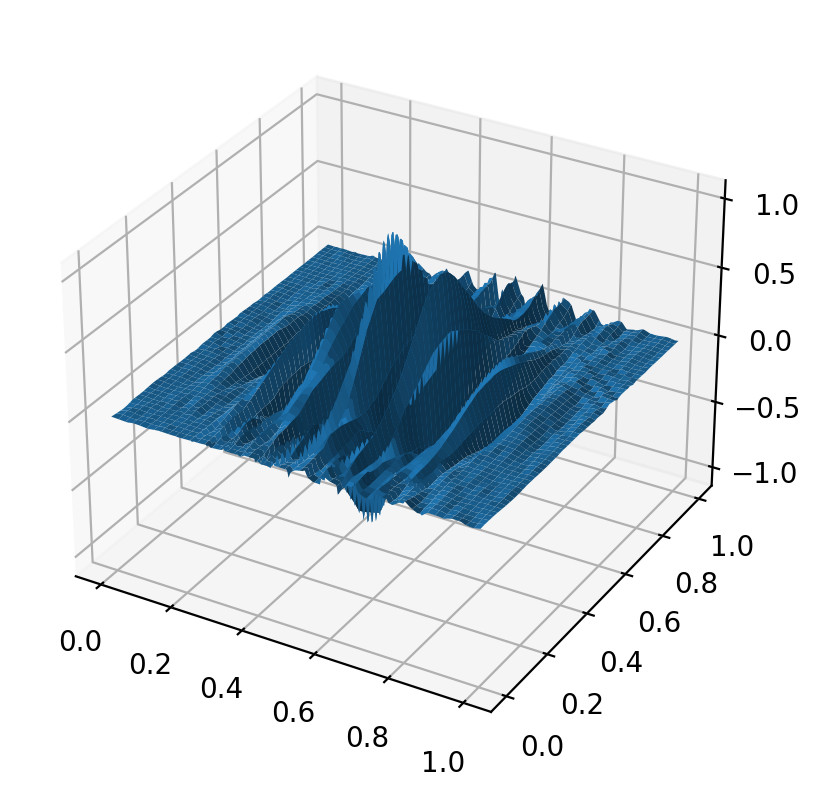

time taken:  12.138344287872314
neuron num 		 error 		 order
4		tensor(0.18676358)		*
8		tensor(0.17429207)		tensor(0.09970619)
16		tensor(0.13720771)		tensor(0.34514541)
32		tensor(0.11845465)		tensor(0.21202674)
64		tensor(0.06757468)		tensor(0.80978020)
128		tensor(0.05024533)		tensor(0.42749306)
256		tensor(0.04963082)		tensor(0.01775325)
512		tensor(0.04958918)		tensor(0.00121091)
using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.0003082752227783203
solving Ax = b time taken:  0.0001571178436279297
epoch:  2	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.00015282630920410156
epoch:  3	assembling the matrix time taken:  0.0002830028533935547
solving Ax = b time taken:  0.0001437664031982422
epoch:  4	assembling the matrix time taken:  0.00027823448181152344
solving Ax = b time taken:  0.00014209747314453125
epoch:  5	assembling the matrix time taken:  0.00028014183044433594
solving Ax = b time taken:  0.0001423358917236328
ep

epoch:  72	assembling the matrix time taken:  0.0003337860107421875
solving Ax = b time taken:  0.0009043216705322266
epoch:  73	assembling the matrix time taken:  0.0003342628479003906
solving Ax = b time taken:  0.0008645057678222656
epoch:  74	assembling the matrix time taken:  0.0003046989440917969
solving Ax = b time taken:  0.0008761882781982422
epoch:  75	assembling the matrix time taken:  0.0003364086151123047
solving Ax = b time taken:  0.0009438991546630859
epoch:  76	assembling the matrix time taken:  0.0003428459167480469
solving Ax = b time taken:  0.0008928775787353516
epoch:  77	assembling the matrix time taken:  0.0003418922424316406
solving Ax = b time taken:  0.0009262561798095703
epoch:  78	assembling the matrix time taken:  0.00034809112548828125
solving Ax = b time taken:  0.0009534358978271484
epoch:  79	assembling the matrix time taken:  0.0003364086151123047
solving Ax = b time taken:  0.0009872913360595703
epoch:  80	assembling the matrix time taken:  0.0003073

epoch:  144	assembling the matrix time taken:  0.0003616809844970703
solving Ax = b time taken:  0.002740621566772461
epoch:  145	assembling the matrix time taken:  0.0003376007080078125
solving Ax = b time taken:  0.0029358863830566406
epoch:  146	assembling the matrix time taken:  0.0003762245178222656
solving Ax = b time taken:  0.002878904342651367
epoch:  147	assembling the matrix time taken:  0.0003275871276855469
solving Ax = b time taken:  0.0029685497283935547
epoch:  148	assembling the matrix time taken:  0.0003330707550048828
solving Ax = b time taken:  0.002902507781982422
epoch:  149	assembling the matrix time taken:  0.00038695335388183594
solving Ax = b time taken:  0.002975940704345703
epoch:  150	assembling the matrix time taken:  0.0003459453582763672
solving Ax = b time taken:  0.0031003952026367188
epoch:  151	assembling the matrix time taken:  0.0003387928009033203
solving Ax = b time taken:  0.003319263458251953
epoch:  152	assembling the matrix time taken:  0.000

epoch:  216	assembling the matrix time taken:  0.00033736228942871094
solving Ax = b time taken:  0.005250453948974609
epoch:  217	assembling the matrix time taken:  0.0003294944763183594
solving Ax = b time taken:  0.0052258968353271484
epoch:  218	assembling the matrix time taken:  0.00035309791564941406
solving Ax = b time taken:  0.005207538604736328
epoch:  219	assembling the matrix time taken:  0.0003638267517089844
solving Ax = b time taken:  0.005593538284301758
epoch:  220	assembling the matrix time taken:  0.0003368854522705078
solving Ax = b time taken:  0.0053899288177490234
epoch:  221	assembling the matrix time taken:  0.00035834312438964844
solving Ax = b time taken:  0.005457401275634766
epoch:  222	assembling the matrix time taken:  0.0003342628479003906
solving Ax = b time taken:  0.005861759185791016
epoch:  223	assembling the matrix time taken:  0.0003364086151123047
solving Ax = b time taken:  0.005501270294189453
epoch:  224	assembling the matrix time taken:  0.00

epoch:  286	assembling the matrix time taken:  0.0003745555877685547
solving Ax = b time taken:  0.008490562438964844
epoch:  287	assembling the matrix time taken:  0.00035881996154785156
solving Ax = b time taken:  0.008746147155761719
epoch:  288	assembling the matrix time taken:  0.0003898143768310547
solving Ax = b time taken:  0.008421897888183594
epoch:  289	assembling the matrix time taken:  0.00033211708068847656
solving Ax = b time taken:  0.00900578498840332
epoch:  290	assembling the matrix time taken:  0.00033974647521972656
solving Ax = b time taken:  0.008840322494506836
epoch:  291	assembling the matrix time taken:  0.0003383159637451172
solving Ax = b time taken:  0.008793830871582031
epoch:  292	assembling the matrix time taken:  0.000362396240234375
solving Ax = b time taken:  0.008959293365478516
epoch:  293	assembling the matrix time taken:  0.0003600120544433594
solving Ax = b time taken:  0.008872509002685547
epoch:  294	assembling the matrix time taken:  0.000330

epoch:  357	assembling the matrix time taken:  0.0003695487976074219
solving Ax = b time taken:  0.012536048889160156
epoch:  358	assembling the matrix time taken:  0.0003287792205810547
solving Ax = b time taken:  0.01287078857421875
epoch:  359	assembling the matrix time taken:  0.0003304481506347656
solving Ax = b time taken:  0.01307821273803711
epoch:  360	assembling the matrix time taken:  0.0003635883331298828
solving Ax = b time taken:  0.012359619140625
epoch:  361	assembling the matrix time taken:  0.000335693359375
solving Ax = b time taken:  0.012902975082397461
epoch:  362	assembling the matrix time taken:  0.0003261566162109375
solving Ax = b time taken:  0.012687206268310547
epoch:  363	assembling the matrix time taken:  0.0003349781036376953
solving Ax = b time taken:  0.012874364852905273
epoch:  364	assembling the matrix time taken:  0.00032830238342285156
solving Ax = b time taken:  0.012729883193969727
epoch:  365	assembling the matrix time taken:  0.000329494476318

epoch:  429	assembling the matrix time taken:  0.0003333091735839844
solving Ax = b time taken:  0.017415523529052734
epoch:  430	assembling the matrix time taken:  0.0003323554992675781
solving Ax = b time taken:  0.01729130744934082
epoch:  431	assembling the matrix time taken:  0.0003314018249511719
solving Ax = b time taken:  0.017778635025024414
epoch:  432	assembling the matrix time taken:  0.00036716461181640625
solving Ax = b time taken:  0.017981529235839844
epoch:  433	assembling the matrix time taken:  0.0003669261932373047
solving Ax = b time taken:  0.0179290771484375
epoch:  434	assembling the matrix time taken:  0.00034236907958984375
solving Ax = b time taken:  0.0180816650390625
epoch:  435	assembling the matrix time taken:  0.0003647804260253906
solving Ax = b time taken:  0.01786041259765625
epoch:  436	assembling the matrix time taken:  0.0003616809844970703
solving Ax = b time taken:  0.01802515983581543
epoch:  437	assembling the matrix time taken:  0.000332832336

epoch:  500	assembling the matrix time taken:  0.0003256797790527344
solving Ax = b time taken:  0.02228832244873047
epoch:  501	assembling the matrix time taken:  0.0003349781036376953
solving Ax = b time taken:  0.022431612014770508
epoch:  502	assembling the matrix time taken:  0.0003695487976074219
solving Ax = b time taken:  0.022282838821411133
epoch:  503	assembling the matrix time taken:  0.00034689903259277344
solving Ax = b time taken:  0.0234835147857666
epoch:  504	assembling the matrix time taken:  0.0003573894500732422
solving Ax = b time taken:  0.02196478843688965
epoch:  505	assembling the matrix time taken:  0.00035881996154785156
solving Ax = b time taken:  0.022917747497558594
epoch:  506	assembling the matrix time taken:  0.0003159046173095703
solving Ax = b time taken:  0.02290511131286621
epoch:  507	assembling the matrix time taken:  0.0003170967102050781
solving Ax = b time taken:  0.02382373809814453
epoch:  508	assembling the matrix time taken:  0.00035500526

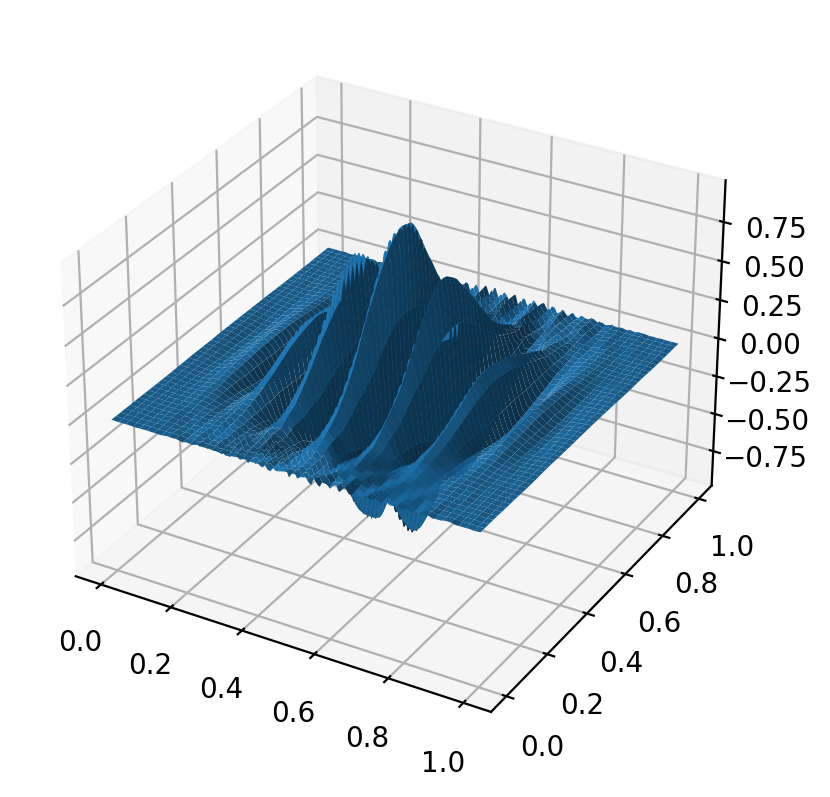

time taken:  24.15009880065918
neuron num 		 error 		 order
4		tensor(0.18593198)		*
8		tensor(0.16281163)		tensor(0.19157120)
16		tensor(0.15241313)		tensor(0.09521660)
32		tensor(0.12363460)		tensor(0.30190463)
64		tensor(0.06885179)		tensor(0.84451640)
128		tensor(0.02471193)		tensor(1.47828664)
256		tensor(0.01077886)		tensor(1.19700235)
512		tensor(0.00666565)		tensor(0.69338874)


In [21]:


def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

function_name = "gabor2d" 
filename_write = "data/2DOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

for N_list in [[2**5,2**5],[2**6,2**6],[2**7,2**7]]: 
    save = True 
    f_write = open(filename_write, "a")
    my_model = None 
    Nx = 50   
    order = 3   
    exponent = 9  
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    N = np.prod(N_list)
    err_QMC2, my_model = OGAL2FittingReLU2D(my_model,target,N_list,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "ls")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_deterministic.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)

    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_QMC2[i] for i in neuron_nums ]
    f_write.write('deterministic dictionary size: {}\n'.format(N))
    f_write.write("neuron num \t\t error \t\t order\n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
            f_write.write("{} \t\t {} \t\t * \n".format(neuron_nums[i],item))
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2)))
    f_write.write("\n")
    f_write.close()



In [ ]:
## 

using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.0003237724304199219
solving Ax = b time taken:  0.00018525123596191406
epoch:  2	assembling the matrix time taken:  0.0003132820129394531
solving Ax = b time taken:  0.00017070770263671875
epoch:  3	assembling the matrix time taken:  0.0003082752227783203
solving Ax = b time taken:  0.00013065338134765625
epoch:  4	assembling the matrix time taken:  0.0003037452697753906
solving Ax = b time taken:  0.0001304149627685547
epoch:  5	assembling the matrix time taken:  0.0002830028533935547
solving Ax = b time taken:  0.0001232624053955078
epoch:  6	assembling the matrix time taken:  0.00027441978454589844
solving Ax = b time taken:  0.00012183189392089844
epoch:  7	assembling the matrix time taken:  0.0002779960632324219
solving Ax = b time taken:  0.0001227855682373047
epoch:  8	assembling the matrix time taken:  0.0002770423889160156
solving Ax = b time taken:  0.00012254714965820312
epoch:  9	assembling the matr

epoch:  118	assembling the matrix time taken:  0.0003485679626464844
solving Ax = b time taken:  0.0008451938629150391
epoch:  119	assembling the matrix time taken:  0.0003566741943359375
solving Ax = b time taken:  0.0008771419525146484
epoch:  120	assembling the matrix time taken:  0.00034928321838378906
solving Ax = b time taken:  0.0008695125579833984
epoch:  121	assembling the matrix time taken:  0.0003554821014404297
solving Ax = b time taken:  0.0008902549743652344
epoch:  122	assembling the matrix time taken:  0.0003447532653808594
solving Ax = b time taken:  0.0008957386016845703
epoch:  123	assembling the matrix time taken:  0.00034546852111816406
solving Ax = b time taken:  0.0009026527404785156
epoch:  124	assembling the matrix time taken:  0.0003476142883300781
solving Ax = b time taken:  0.0008981227874755859
epoch:  125	assembling the matrix time taken:  0.0003452301025390625
solving Ax = b time taken:  0.0009272098541259766
epoch:  126	assembling the matrix time taken: 

epoch:  193	assembling the matrix time taken:  0.0003814697265625
solving Ax = b time taken:  0.0014767646789550781
epoch:  194	assembling the matrix time taken:  0.00034546852111816406
solving Ax = b time taken:  0.0015354156494140625
epoch:  195	assembling the matrix time taken:  0.00032782554626464844
solving Ax = b time taken:  0.0015537738800048828
epoch:  196	assembling the matrix time taken:  0.0003590583801269531
solving Ax = b time taken:  0.0015099048614501953
epoch:  197	assembling the matrix time taken:  0.0003612041473388672
solving Ax = b time taken:  0.0015442371368408203
epoch:  198	assembling the matrix time taken:  0.0003631114959716797
solving Ax = b time taken:  0.0015413761138916016
epoch:  199	assembling the matrix time taken:  0.00032973289489746094
solving Ax = b time taken:  0.001573324203491211
epoch:  200	assembling the matrix time taken:  0.00036454200744628906
solving Ax = b time taken:  0.0015249252319335938
epoch:  201	assembling the matrix time taken:  0

epoch:  277	assembling the matrix time taken:  0.0008170604705810547
solving Ax = b time taken:  0.002111673355102539
epoch:  278	assembling the matrix time taken:  0.0003726482391357422
solving Ax = b time taken:  0.002534151077270508
epoch:  279	assembling the matrix time taken:  0.0005559921264648438
solving Ax = b time taken:  0.0023984909057617188
epoch:  280	assembling the matrix time taken:  0.0005006790161132812
solving Ax = b time taken:  0.0024187564849853516
epoch:  281	assembling the matrix time taken:  0.00038814544677734375
solving Ax = b time taken:  0.0025370121002197266
epoch:  282	assembling the matrix time taken:  0.0003676414489746094
solving Ax = b time taken:  0.0025496482849121094
epoch:  283	assembling the matrix time taken:  0.0003719329833984375
solving Ax = b time taken:  0.002561807632446289
epoch:  284	assembling the matrix time taken:  0.00036716461181640625
solving Ax = b time taken:  0.002541065216064453
epoch:  285	assembling the matrix time taken:  0.0

epoch:  363	assembling the matrix time taken:  0.00032520294189453125
solving Ax = b time taken:  0.0034754276275634766
epoch:  364	assembling the matrix time taken:  0.0003361701965332031
solving Ax = b time taken:  0.003429412841796875
epoch:  365	assembling the matrix time taken:  0.0005228519439697266
solving Ax = b time taken:  0.003347635269165039
epoch:  366	assembling the matrix time taken:  0.0004749298095703125
solving Ax = b time taken:  0.0033469200134277344
epoch:  367	assembling the matrix time taken:  0.0003807544708251953
solving Ax = b time taken:  0.0034303665161132812
epoch:  368	assembling the matrix time taken:  0.0003800392150878906
solving Ax = b time taken:  0.0033922195434570312
epoch:  369	assembling the matrix time taken:  0.0003407001495361328
solving Ax = b time taken:  0.0035173892974853516
epoch:  370	assembling the matrix time taken:  0.00044345855712890625
solving Ax = b time taken:  0.003435850143432617
epoch:  371	assembling the matrix time taken:  0.

epoch:  433	assembling the matrix time taken:  0.0004181861877441406
solving Ax = b time taken:  0.004319429397583008
epoch:  434	assembling the matrix time taken:  0.00038909912109375
solving Ax = b time taken:  0.004324913024902344
epoch:  435	assembling the matrix time taken:  0.0003705024719238281
solving Ax = b time taken:  0.004375457763671875
epoch:  436	assembling the matrix time taken:  0.0003743171691894531
solving Ax = b time taken:  0.004319906234741211
epoch:  437	assembling the matrix time taken:  0.0003459453582763672
solving Ax = b time taken:  0.004410505294799805
epoch:  438	assembling the matrix time taken:  0.00033473968505859375
solving Ax = b time taken:  0.0044138431549072266
epoch:  439	assembling the matrix time taken:  0.00033736228942871094
solving Ax = b time taken:  0.004425764083862305
epoch:  440	assembling the matrix time taken:  0.0003418922424316406
solving Ax = b time taken:  0.0043811798095703125
epoch:  441	assembling the matrix time taken:  0.00048

solving Ax = b time taken:  0.004919767379760742
epoch:  509	assembling the matrix time taken:  0.0003180503845214844
solving Ax = b time taken:  0.0051267147064208984
epoch:  510	assembling the matrix time taken:  0.0003170967102050781
solving Ax = b time taken:  0.0051038265228271484
epoch:  511	assembling the matrix time taken:  0.0003161430358886719
solving Ax = b time taken:  0.005115985870361328
epoch:  512	assembling the matrix time taken:  0.00031447410583496094
solving Ax = b time taken:  0.005090951919555664


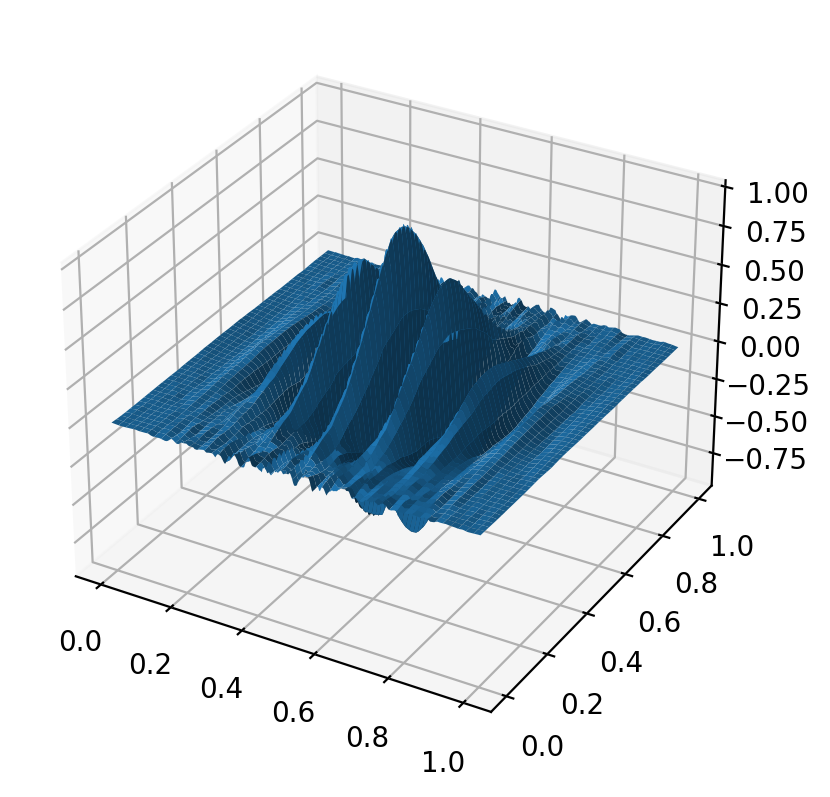

time taken:  4.648831367492676
neuron num 		 error 		 order
4		tensor(0.18798803)		*
8		tensor(0.18722389)		tensor(0.00587624)
16		tensor(0.18123192)		tensor(0.04692747)
32		tensor(0.17416160)		tensor(0.05741053)
64		tensor(0.11881924)		tensor(0.55165810)
128		tensor(0.05809528)		tensor(1.03227569)
256		tensor(0.02061482)		tensor(1.49473917)
512		tensor(0.00877727)		tensor(1.23183692)
using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.0003020763397216797
solving Ax = b time taken:  0.0001850128173828125
epoch:  2	assembling the matrix time taken:  0.00029468536376953125
solving Ax = b time taken:  0.00014495849609375
epoch:  3	assembling the matrix time taken:  0.00028014183044433594
solving Ax = b time taken:  0.0001266002655029297
epoch:  4	assembling the matrix time taken:  0.00027632713317871094
solving Ax = b time taken:  0.00012373924255371094
epoch:  5	assembling the matrix time taken:  0.0002758502960205078
solving Ax = b time taken:  0.0001296997070312

epoch:  115	assembling the matrix time taken:  0.0005383491516113281
solving Ax = b time taken:  0.0006062984466552734
epoch:  116	assembling the matrix time taken:  0.0004591941833496094
solving Ax = b time taken:  0.0007045269012451172
epoch:  117	assembling the matrix time taken:  0.0003643035888671875
solving Ax = b time taken:  0.0007905960083007812
epoch:  118	assembling the matrix time taken:  0.00034356117248535156
solving Ax = b time taken:  0.0008127689361572266
epoch:  119	assembling the matrix time taken:  0.0003464221954345703
solving Ax = b time taken:  0.0008211135864257812
epoch:  120	assembling the matrix time taken:  0.0003561973571777344
solving Ax = b time taken:  0.0008118152618408203
epoch:  121	assembling the matrix time taken:  0.0003421306610107422
solving Ax = b time taken:  0.0008356571197509766
epoch:  122	assembling the matrix time taken:  0.00034356117248535156
solving Ax = b time taken:  0.0008397102355957031
epoch:  123	assembling the matrix time taken: 

epoch:  188	assembling the matrix time taken:  0.00104522705078125
solving Ax = b time taken:  0.0008749961853027344
epoch:  189	assembling the matrix time taken:  0.0005853176116943359
solving Ax = b time taken:  0.001135110855102539
epoch:  190	assembling the matrix time taken:  0.0003979206085205078
solving Ax = b time taken:  0.0012705326080322266
epoch:  191	assembling the matrix time taken:  0.00037670135498046875
solving Ax = b time taken:  0.0012969970703125
epoch:  192	assembling the matrix time taken:  0.0003743171691894531
solving Ax = b time taken:  0.001293182373046875
epoch:  193	assembling the matrix time taken:  0.0003745555877685547
solving Ax = b time taken:  0.0015075206756591797
epoch:  194	assembling the matrix time taken:  0.0003695487976074219
solving Ax = b time taken:  0.0015037059783935547
epoch:  195	assembling the matrix time taken:  0.00037550926208496094
solving Ax = b time taken:  0.0015096664428710938
epoch:  196	assembling the matrix time taken:  0.0003

epoch:  272	assembling the matrix time taken:  0.0003762245178222656
solving Ax = b time taken:  0.0024106502532958984
epoch:  273	assembling the matrix time taken:  0.0003726482391357422
solving Ax = b time taken:  0.002500772476196289
epoch:  274	assembling the matrix time taken:  0.00036525726318359375
solving Ax = b time taken:  0.0025017261505126953
epoch:  275	assembling the matrix time taken:  0.00037288665771484375
solving Ax = b time taken:  0.0025055408477783203
epoch:  276	assembling the matrix time taken:  0.0003292560577392578
solving Ax = b time taken:  0.0025305747985839844
epoch:  277	assembling the matrix time taken:  0.0003719329833984375
solving Ax = b time taken:  0.0025129318237304688
epoch:  278	assembling the matrix time taken:  0.0003666877746582031
solving Ax = b time taken:  0.0025207996368408203
epoch:  279	assembling the matrix time taken:  0.00033354759216308594
solving Ax = b time taken:  0.0025784969329833984
epoch:  280	assembling the matrix time taken: 

epoch:  357	assembling the matrix time taken:  0.0003724098205566406
solving Ax = b time taken:  0.0033500194549560547
epoch:  358	assembling the matrix time taken:  0.0003657341003417969
solving Ax = b time taken:  0.003381490707397461
epoch:  359	assembling the matrix time taken:  0.0003349781036376953
solving Ax = b time taken:  0.0034215450286865234
epoch:  360	assembling the matrix time taken:  0.00034236907958984375
solving Ax = b time taken:  0.003387451171875
epoch:  361	assembling the matrix time taken:  0.0003330707550048828
solving Ax = b time taken:  0.0034422874450683594
epoch:  362	assembling the matrix time taken:  0.00033402442932128906
solving Ax = b time taken:  0.003435373306274414
epoch:  363	assembling the matrix time taken:  0.0003368854522705078
solving Ax = b time taken:  0.0034475326538085938
epoch:  364	assembling the matrix time taken:  0.00033283233642578125
solving Ax = b time taken:  0.0034286975860595703
epoch:  365	assembling the matrix time taken:  0.00

solving Ax = b time taken:  0.0042612552642822266
epoch:  428	assembling the matrix time taken:  0.00037741661071777344
solving Ax = b time taken:  0.0042569637298583984
epoch:  429	assembling the matrix time taken:  0.0003399848937988281
solving Ax = b time taken:  0.00434565544128418
epoch:  430	assembling the matrix time taken:  0.000339508056640625
solving Ax = b time taken:  0.004343271255493164
epoch:  431	assembling the matrix time taken:  0.00034689903259277344
solving Ax = b time taken:  0.004349231719970703
epoch:  432	assembling the matrix time taken:  0.0003390312194824219
solving Ax = b time taken:  0.004319429397583008
epoch:  433	assembling the matrix time taken:  0.00034809112548828125
solving Ax = b time taken:  0.00438690185546875
epoch:  434	assembling the matrix time taken:  0.0003371238708496094
solving Ax = b time taken:  0.004395246505737305
epoch:  435	assembling the matrix time taken:  0.00038814544677734375
solving Ax = b time taken:  0.00439000129699707
epoch

solving Ax = b time taken:  0.004976987838745117
epoch:  504	assembling the matrix time taken:  0.00042247772216796875
solving Ax = b time taken:  0.0049228668212890625
epoch:  505	assembling the matrix time taken:  0.0003261566162109375
solving Ax = b time taken:  0.00508880615234375
epoch:  506	assembling the matrix time taken:  0.0003390312194824219
solving Ax = b time taken:  0.00506901741027832
epoch:  507	assembling the matrix time taken:  0.0003330707550048828
solving Ax = b time taken:  0.005082130432128906
epoch:  508	assembling the matrix time taken:  0.00032329559326171875
solving Ax = b time taken:  0.00506138801574707
epoch:  509	assembling the matrix time taken:  0.00035381317138671875
solving Ax = b time taken:  0.005075216293334961
epoch:  510	assembling the matrix time taken:  0.0003464221954345703
solving Ax = b time taken:  0.005095958709716797
epoch:  511	assembling the matrix time taken:  0.00047588348388671875
solving Ax = b time taken:  0.004972219467163086
epoch

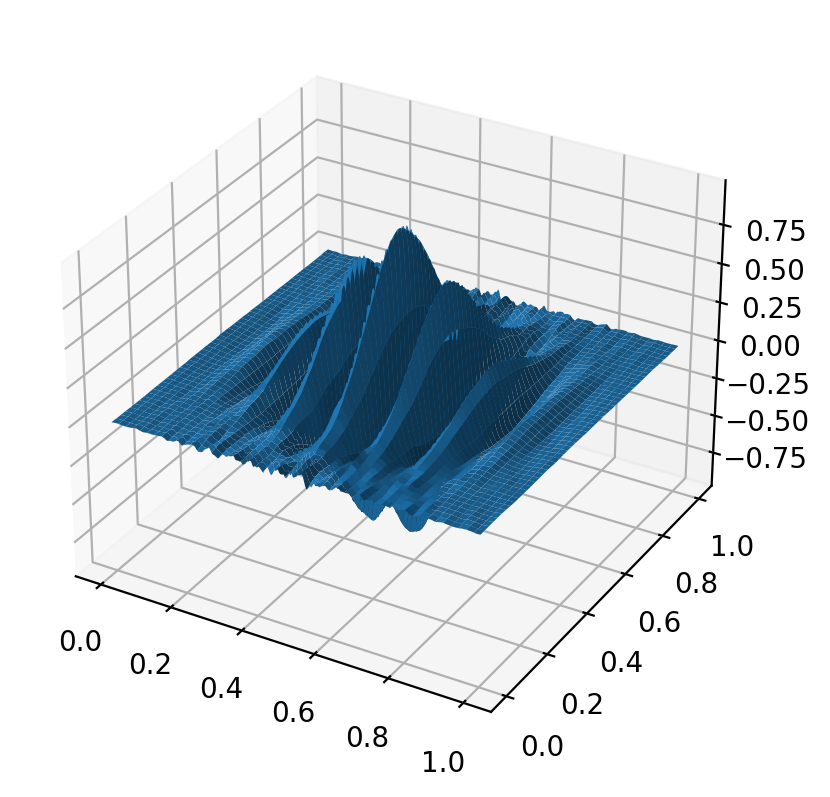

time taken:  4.708756685256958
neuron num 		 error 		 order
4		tensor(0.18798958)		*
8		tensor(0.18780643)		tensor(0.00140621)
16		tensor(0.18528072)		tensor(0.01953377)
32		tensor(0.14468900)		tensor(0.35675748)
64		tensor(0.10899137)		tensor(0.40874128)
128		tensor(0.04294863)		tensor(1.34353008)
256		tensor(0.01644521)		tensor(1.38494494)
512		tensor(0.00695872)		tensor(1.24077385)
using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.0003218650817871094
solving Ax = b time taken:  0.0001811981201171875
epoch:  2	assembling the matrix time taken:  0.0002963542938232422
solving Ax = b time taken:  0.0001506805419921875
epoch:  3	assembling the matrix time taken:  0.0002903938293457031
solving Ax = b time taken:  0.00012493133544921875
epoch:  4	assembling the matrix time taken:  0.00027751922607421875
solving Ax = b time taken:  0.000125885009765625
epoch:  5	assembling the matrix time taken:  0.0003058910369873047
solving Ax = b time taken:  0.00014328956604003

epoch:  109	assembling the matrix time taken:  0.000385284423828125
solving Ax = b time taken:  0.0006883144378662109
epoch:  110	assembling the matrix time taken:  0.00035071372985839844
solving Ax = b time taken:  0.0006253719329833984
epoch:  111	assembling the matrix time taken:  0.00032401084899902344
solving Ax = b time taken:  0.0006537437438964844
epoch:  112	assembling the matrix time taken:  0.0003628730773925781
solving Ax = b time taken:  0.0006072521209716797
epoch:  113	assembling the matrix time taken:  0.00032329559326171875
solving Ax = b time taken:  0.0006730556488037109
epoch:  114	assembling the matrix time taken:  0.00034308433532714844
solving Ax = b time taken:  0.0006563663482666016
epoch:  115	assembling the matrix time taken:  0.0003616809844970703
solving Ax = b time taken:  0.0007884502410888672
epoch:  116	assembling the matrix time taken:  0.00036907196044921875
solving Ax = b time taken:  0.0007708072662353516
epoch:  117	assembling the matrix time taken

epoch:  181	assembling the matrix time taken:  0.00039386749267578125
solving Ax = b time taken:  0.0012402534484863281
epoch:  182	assembling the matrix time taken:  0.00036716461181640625
solving Ax = b time taken:  0.0012645721435546875
epoch:  183	assembling the matrix time taken:  0.0003688335418701172
solving Ax = b time taken:  0.0012717247009277344
epoch:  184	assembling the matrix time taken:  0.00037789344787597656
solving Ax = b time taken:  0.0012497901916503906
epoch:  185	assembling the matrix time taken:  0.0003352165222167969
solving Ax = b time taken:  0.0013196468353271484
epoch:  186	assembling the matrix time taken:  0.0003681182861328125
solving Ax = b time taken:  0.0012898445129394531
epoch:  187	assembling the matrix time taken:  0.00034427642822265625
solving Ax = b time taken:  0.0013165473937988281
epoch:  188	assembling the matrix time taken:  0.0003306865692138672
solving Ax = b time taken:  0.0013289451599121094
epoch:  189	assembling the matrix time taken

solving Ax = b time taken:  0.002366304397583008
epoch:  264	assembling the matrix time taken:  0.0003886222839355469
solving Ax = b time taken:  0.002346038818359375
epoch:  265	assembling the matrix time taken:  0.0003693103790283203
solving Ax = b time taken:  0.002407073974609375
epoch:  266	assembling the matrix time taken:  0.00037789344787597656
solving Ax = b time taken:  0.002412557601928711
epoch:  267	assembling the matrix time taken:  0.0003719329833984375
solving Ax = b time taken:  0.0024144649505615234
epoch:  268	assembling the matrix time taken:  0.0003478527069091797
solving Ax = b time taken:  0.0024192333221435547
epoch:  269	assembling the matrix time taken:  0.0003516674041748047
solving Ax = b time taken:  0.0024726390838623047
epoch:  270	assembling the matrix time taken:  0.00038170814514160156
solving Ax = b time taken:  0.0024437904357910156
epoch:  271	assembling the matrix time taken:  0.00039386749267578125
solving Ax = b time taken:  0.0024290084838867188

solving Ax = b time taken:  0.0031833648681640625
epoch:  349	assembling the matrix time taken:  0.0004754066467285156
solving Ax = b time taken:  0.0032422542572021484
epoch:  350	assembling the matrix time taken:  0.00033783912658691406
solving Ax = b time taken:  0.0033502578735351562
epoch:  351	assembling the matrix time taken:  0.0003440380096435547
solving Ax = b time taken:  0.0033376216888427734
epoch:  352	assembling the matrix time taken:  0.00036787986755371094
solving Ax = b time taken:  0.0032885074615478516
epoch:  353	assembling the matrix time taken:  0.000335693359375
solving Ax = b time taken:  0.0034003257751464844
epoch:  354	assembling the matrix time taken:  0.0003418922424316406
solving Ax = b time taken:  0.003390073776245117
epoch:  355	assembling the matrix time taken:  0.0003674030303955078
solving Ax = b time taken:  0.0033774375915527344
epoch:  356	assembling the matrix time taken:  0.0003294944763183594
solving Ax = b time taken:  0.003389596939086914
ep

solving Ax = b time taken:  0.004279136657714844
epoch:  419	assembling the matrix time taken:  0.0003781318664550781
solving Ax = b time taken:  0.0042612552642822266
epoch:  420	assembling the matrix time taken:  0.0003714561462402344
solving Ax = b time taken:  0.0042307376861572266
epoch:  421	assembling the matrix time taken:  0.00039505958557128906
solving Ax = b time taken:  0.004296064376831055
epoch:  422	assembling the matrix time taken:  0.00054168701171875
solving Ax = b time taken:  0.00414276123046875
epoch:  423	assembling the matrix time taken:  0.00038814544677734375
solving Ax = b time taken:  0.004253387451171875
epoch:  424	assembling the matrix time taken:  0.0003485679626464844
solving Ax = b time taken:  0.004273176193237305
epoch:  425	assembling the matrix time taken:  0.00035691261291503906
solving Ax = b time taken:  0.004315853118896484
epoch:  426	assembling the matrix time taken:  0.00037789344787597656
solving Ax = b time taken:  0.004287242889404297
epoc

solving Ax = b time taken:  0.0049896240234375
epoch:  494	assembling the matrix time taken:  0.0003323554992675781
solving Ax = b time taken:  0.0049953460693359375
epoch:  495	assembling the matrix time taken:  0.0003199577331542969
solving Ax = b time taken:  0.004999637603759766
epoch:  496	assembling the matrix time taken:  0.00047206878662109375
solving Ax = b time taken:  0.004870176315307617
epoch:  497	assembling the matrix time taken:  0.0003452301025390625
solving Ax = b time taken:  0.0050258636474609375
epoch:  498	assembling the matrix time taken:  0.0003299713134765625
solving Ax = b time taken:  0.005040884017944336
epoch:  499	assembling the matrix time taken:  0.0003619194030761719
solving Ax = b time taken:  0.0050275325775146484
epoch:  500	assembling the matrix time taken:  0.00032210350036621094
solving Ax = b time taken:  0.005018711090087891
epoch:  501	assembling the matrix time taken:  0.0003230571746826172
solving Ax = b time taken:  0.005068540573120117
epoc

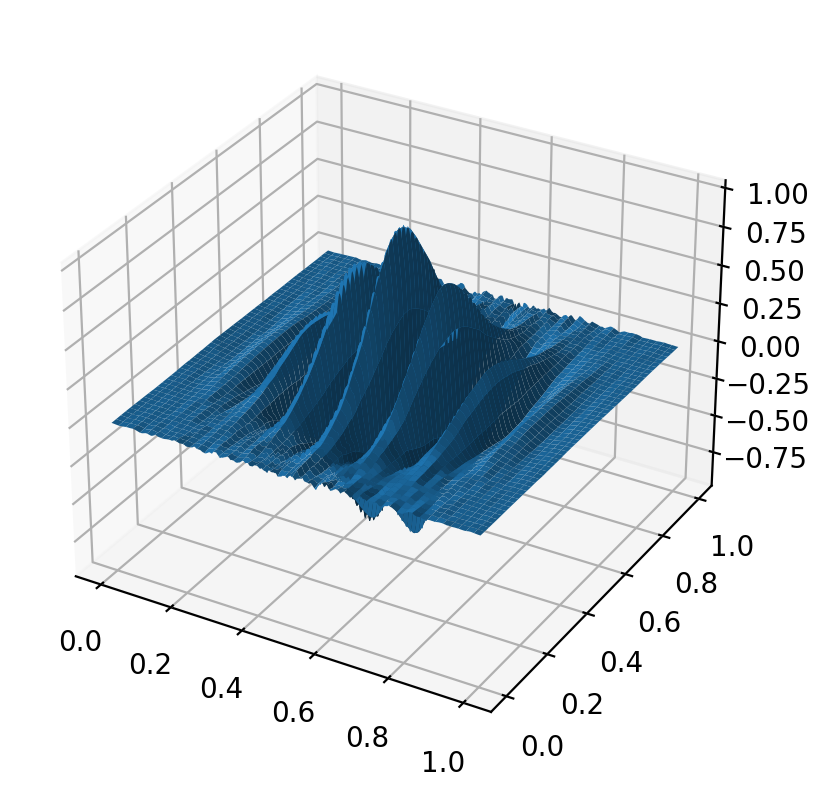

time taken:  4.859005451202393
neuron num 		 error 		 order
4		tensor(0.18794810)		*
8		tensor(0.18755597)		tensor(0.00301309)
16		tensor(0.16582086)		tensor(0.17769571)
32		tensor(0.11324635)		tensor(0.55016092)
64		tensor(0.06317029)		tensor(0.84214646)
128		tensor(0.03020805)		tensor(1.06431331)
256		tensor(0.01327884)		tensor(1.18580354)
512		tensor(0.00533631)		tensor(1.31521428)
using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.00034117698669433594
solving Ax = b time taken:  0.00020003318786621094
epoch:  2	assembling the matrix time taken:  0.00038361549377441406
solving Ax = b time taken:  0.0001983642578125
epoch:  3	assembling the matrix time taken:  0.000400543212890625
solving Ax = b time taken:  0.00020885467529296875
epoch:  4	assembling the matrix time taken:  0.00040268898010253906
solving Ax = b time taken:  0.00020194053649902344
epoch:  5	assembling the matrix time taken:  0.0004177093505859375
solving Ax = b time taken:  0.0002062320709228

epoch:  98	assembling the matrix time taken:  0.0003142356872558594
solving Ax = b time taken:  0.0005762577056884766
epoch:  99	assembling the matrix time taken:  0.0003151893615722656
solving Ax = b time taken:  0.0005884170532226562
epoch:  100	assembling the matrix time taken:  0.00031113624572753906
solving Ax = b time taken:  0.0005872249603271484
epoch:  101	assembling the matrix time taken:  0.0003426074981689453
solving Ax = b time taken:  0.0005698204040527344
epoch:  102	assembling the matrix time taken:  0.00034499168395996094
solving Ax = b time taken:  0.0005712509155273438
epoch:  103	assembling the matrix time taken:  0.00034165382385253906
solving Ax = b time taken:  0.0005788803100585938
epoch:  104	assembling the matrix time taken:  0.00034999847412109375
solving Ax = b time taken:  0.0005702972412109375
epoch:  105	assembling the matrix time taken:  0.0003409385681152344
solving Ax = b time taken:  0.0005896091461181641
epoch:  106	assembling the matrix time taken: 

epoch:  167	assembling the matrix time taken:  0.0003833770751953125
solving Ax = b time taken:  0.001283407211303711
epoch:  168	assembling the matrix time taken:  0.000335693359375
solving Ax = b time taken:  0.00135040283203125
epoch:  169	assembling the matrix time taken:  0.0003643035888671875
solving Ax = b time taken:  0.0011909008026123047
epoch:  170	assembling the matrix time taken:  0.00037741661071777344
solving Ax = b time taken:  0.0011725425720214844
epoch:  171	assembling the matrix time taken:  0.0003604888916015625
solving Ax = b time taken:  0.0011973381042480469
epoch:  172	assembling the matrix time taken:  0.0003795623779296875
solving Ax = b time taken:  0.0011639595031738281
epoch:  173	assembling the matrix time taken:  0.00033473968505859375
solving Ax = b time taken:  0.0012388229370117188
epoch:  174	assembling the matrix time taken:  0.0003745555877685547
solving Ax = b time taken:  0.0012009143829345703
epoch:  175	assembling the matrix time taken:  0.0003

epoch:  248	assembling the matrix time taken:  0.0003845691680908203
solving Ax = b time taken:  0.0017960071563720703
epoch:  249	assembling the matrix time taken:  0.0003790855407714844
solving Ax = b time taken:  0.0018568038940429688
epoch:  250	assembling the matrix time taken:  0.0003688335418701172
solving Ax = b time taken:  0.0018613338470458984
epoch:  251	assembling the matrix time taken:  0.0003726482391357422
solving Ax = b time taken:  0.0018711090087890625
epoch:  252	assembling the matrix time taken:  0.00038051605224609375
solving Ax = b time taken:  0.0018417835235595703
epoch:  253	assembling the matrix time taken:  0.00037288665771484375
solving Ax = b time taken:  0.0018892288208007812
epoch:  254	assembling the matrix time taken:  0.00034236907958984375
solving Ax = b time taken:  0.0019125938415527344
epoch:  255	assembling the matrix time taken:  0.0003654956817626953
solving Ax = b time taken:  0.0018935203552246094
epoch:  256	assembling the matrix time taken:

epoch:  332	assembling the matrix time taken:  0.000396728515625
solving Ax = b time taken:  0.0030989646911621094
epoch:  333	assembling the matrix time taken:  0.00034546852111816406
solving Ax = b time taken:  0.003211498260498047
epoch:  334	assembling the matrix time taken:  0.0003426074981689453
solving Ax = b time taken:  0.003206491470336914
epoch:  335	assembling the matrix time taken:  0.00038623809814453125
solving Ax = b time taken:  0.003167390823364258
epoch:  336	assembling the matrix time taken:  0.0003693103790283203
solving Ax = b time taken:  0.0031626224517822266
epoch:  337	assembling the matrix time taken:  0.0003719329833984375
solving Ax = b time taken:  0.00324249267578125
epoch:  338	assembling the matrix time taken:  0.00036787986755371094
solving Ax = b time taken:  0.0032351016998291016
epoch:  339	assembling the matrix time taken:  0.0003685951232910156
solving Ax = b time taken:  0.0032579898834228516
epoch:  340	assembling the matrix time taken:  0.00037

epoch:  417	assembling the matrix time taken:  0.0005006790161132812
solving Ax = b time taken:  0.004114389419555664
epoch:  418	assembling the matrix time taken:  0.00038313865661621094
solving Ax = b time taken:  0.0042400360107421875
epoch:  419	assembling the matrix time taken:  0.0003788471221923828
solving Ax = b time taken:  0.004251241683959961
epoch:  420	assembling the matrix time taken:  0.0003788471221923828
solving Ax = b time taken:  0.0042057037353515625
epoch:  421	assembling the matrix time taken:  0.00034308433532714844
solving Ax = b time taken:  0.004305362701416016
epoch:  422	assembling the matrix time taken:  0.0003807544708251953
solving Ax = b time taken:  0.004259347915649414
epoch:  423	assembling the matrix time taken:  0.0003485679626464844
solving Ax = b time taken:  0.004296302795410156
epoch:  424	assembling the matrix time taken:  0.00037384033203125
solving Ax = b time taken:  0.004241943359375
epoch:  425	assembling the matrix time taken:  0.00050592

epoch:  490	assembling the matrix time taken:  0.0005033016204833984
solving Ax = b time taken:  0.004784822463989258
epoch:  491	assembling the matrix time taken:  0.00033974647521972656
solving Ax = b time taken:  0.004969596862792969
epoch:  492	assembling the matrix time taken:  0.0003223419189453125
solving Ax = b time taken:  0.0049397945404052734
epoch:  493	assembling the matrix time taken:  0.0003249645233154297
solving Ax = b time taken:  0.005007266998291016
epoch:  494	assembling the matrix time taken:  0.0003528594970703125
solving Ax = b time taken:  0.004960060119628906
epoch:  495	assembling the matrix time taken:  0.00032901763916015625
solving Ax = b time taken:  0.004987955093383789
epoch:  496	assembling the matrix time taken:  0.00031948089599609375
solving Ax = b time taken:  0.0049593448638916016
epoch:  497	assembling the matrix time taken:  0.00047779083251953125
solving Ax = b time taken:  0.00495600700378418
epoch:  498	assembling the matrix time taken:  0.00

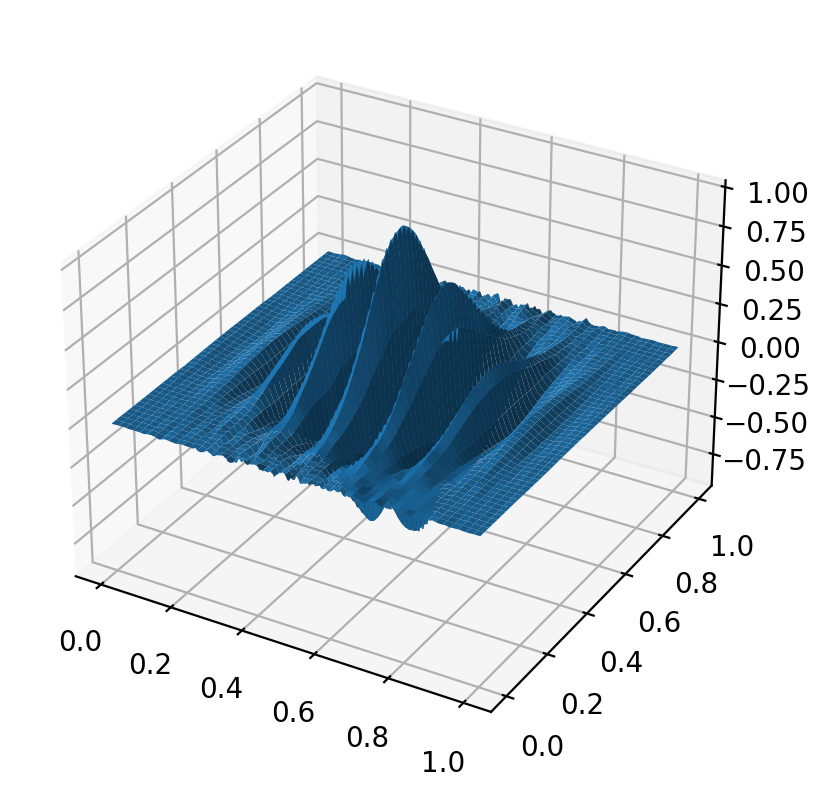

time taken:  5.127780199050903
neuron num 		 error 		 order
4		tensor(0.18766388)		*
8		tensor(0.18553135)		tensor(0.01648804)
16		tensor(0.18109163)		tensor(0.03494310)
32		tensor(0.13322128)		tensor(0.44289537)
64		tensor(0.07734058)		tensor(0.78452701)
128		tensor(0.03634762)		tensor(1.08936484)
256		tensor(0.01230649)		tensor(1.56244196)
512		tensor(0.00476258)		tensor(1.36960440)
using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.00030517578125
solving Ax = b time taken:  0.00018286705017089844
epoch:  2	assembling the matrix time taken:  0.0002925395965576172
solving Ax = b time taken:  0.00015211105346679688
epoch:  3	assembling the matrix time taken:  0.0002856254577636719
solving Ax = b time taken:  0.0001430511474609375
epoch:  4	assembling the matrix time taken:  0.0002846717834472656
solving Ax = b time taken:  0.0001316070556640625
epoch:  5	assembling the matrix time taken:  0.0003509521484375
solving Ax = b time taken:  0.0001590251922607422
epoc

epoch:  79	assembling the matrix time taken:  0.00032520294189453125
solving Ax = b time taken:  0.0004222393035888672
epoch:  80	assembling the matrix time taken:  0.00030612945556640625
solving Ax = b time taken:  0.0004534721374511719
epoch:  81	assembling the matrix time taken:  0.0003101825714111328
solving Ax = b time taken:  0.0004851818084716797
epoch:  82	assembling the matrix time taken:  0.00031113624572753906
solving Ax = b time taken:  0.0004966259002685547
epoch:  83	assembling the matrix time taken:  0.0003180503845214844
solving Ax = b time taken:  0.00048828125
epoch:  84	assembling the matrix time taken:  0.0003542900085449219
solving Ax = b time taken:  0.00045943260192871094
epoch:  85	assembling the matrix time taken:  0.0003185272216796875
solving Ax = b time taken:  0.0004987716674804688
epoch:  86	assembling the matrix time taken:  0.00030922889709472656
solving Ax = b time taken:  0.0005097389221191406
epoch:  87	assembling the matrix time taken:  0.00031757354

epoch:  170	assembling the matrix time taken:  0.000370025634765625
solving Ax = b time taken:  0.0011658668518066406
epoch:  171	assembling the matrix time taken:  0.00038504600524902344
solving Ax = b time taken:  0.0011801719665527344
epoch:  172	assembling the matrix time taken:  0.0003733634948730469
solving Ax = b time taken:  0.0011854171752929688
epoch:  173	assembling the matrix time taken:  0.0003528594970703125
solving Ax = b time taken:  0.001233816146850586
epoch:  174	assembling the matrix time taken:  0.00037217140197753906
solving Ax = b time taken:  0.001220703125
epoch:  175	assembling the matrix time taken:  0.0005316734313964844
solving Ax = b time taken:  0.0011210441589355469
epoch:  176	assembling the matrix time taken:  0.0005087852478027344
solving Ax = b time taken:  0.0010955333709716797
epoch:  177	assembling the matrix time taken:  0.00038170814514160156
solving Ax = b time taken:  0.0012392997741699219
epoch:  178	assembling the matrix time taken:  0.00037

solving Ax = b time taken:  0.0018820762634277344
epoch:  242	assembling the matrix time taken:  0.0004811286926269531
solving Ax = b time taken:  0.0017313957214355469
epoch:  243	assembling the matrix time taken:  0.0003795623779296875
solving Ax = b time taken:  0.0018341541290283203
epoch:  244	assembling the matrix time taken:  0.00035262107849121094
solving Ax = b time taken:  0.0018379688262939453
epoch:  245	assembling the matrix time taken:  0.0003705024719238281
solving Ax = b time taken:  0.0018465518951416016
epoch:  246	assembling the matrix time taken:  0.0003859996795654297
solving Ax = b time taken:  0.0018360614776611328
epoch:  247	assembling the matrix time taken:  0.0003826618194580078
solving Ax = b time taken:  0.0018527507781982422
epoch:  248	assembling the matrix time taken:  0.00041222572326660156
solving Ax = b time taken:  0.001790761947631836
epoch:  249	assembling the matrix time taken:  0.0003376007080078125
solving Ax = b time taken:  0.00191092491149902

solving Ax = b time taken:  0.002799510955810547
epoch:  320	assembling the matrix time taken:  0.0003380775451660156
solving Ax = b time taken:  0.0028100013732910156
epoch:  321	assembling the matrix time taken:  0.00036525726318359375
solving Ax = b time taken:  0.0031194686889648438
epoch:  322	assembling the matrix time taken:  0.0003719329833984375
solving Ax = b time taken:  0.00311279296875
epoch:  323	assembling the matrix time taken:  0.0005309581756591797
solving Ax = b time taken:  0.003018617630004883
epoch:  324	assembling the matrix time taken:  0.00046324729919433594
solving Ax = b time taken:  0.003008604049682617
epoch:  325	assembling the matrix time taken:  0.00037789344787597656
solving Ax = b time taken:  0.003134489059448242
epoch:  326	assembling the matrix time taken:  0.0003426074981689453
solving Ax = b time taken:  0.003170013427734375
epoch:  327	assembling the matrix time taken:  0.0003509521484375
solving Ax = b time taken:  0.0031518936157226562
epoch:  

epoch:  400	assembling the matrix time taken:  0.000385284423828125
solving Ax = b time taken:  0.004006624221801758
epoch:  401	assembling the matrix time taken:  0.00035071372985839844
solving Ax = b time taken:  0.0041539669036865234
epoch:  402	assembling the matrix time taken:  0.00034236907958984375
solving Ax = b time taken:  0.004150867462158203
epoch:  403	assembling the matrix time taken:  0.0003497600555419922
solving Ax = b time taken:  0.004170656204223633
epoch:  404	assembling the matrix time taken:  0.00033926963806152344
solving Ax = b time taken:  0.004128694534301758
epoch:  405	assembling the matrix time taken:  0.00033974647521972656
solving Ax = b time taken:  0.004189491271972656
epoch:  406	assembling the matrix time taken:  0.00035071372985839844
solving Ax = b time taken:  0.0041582584381103516
epoch:  407	assembling the matrix time taken:  0.0004839897155761719
solving Ax = b time taken:  0.004102230072021484
epoch:  408	assembling the matrix time taken:  0.0

epoch:  470	assembling the matrix time taken:  0.0003814697265625
solving Ax = b time taken:  0.004723310470581055
epoch:  471	assembling the matrix time taken:  0.000385284423828125
solving Ax = b time taken:  0.0047757625579833984
epoch:  472	assembling the matrix time taken:  0.0003788471221923828
solving Ax = b time taken:  0.004750967025756836
epoch:  473	assembling the matrix time taken:  0.0003514289855957031
solving Ax = b time taken:  0.0048253536224365234
epoch:  474	assembling the matrix time taken:  0.00036263465881347656
solving Ax = b time taken:  0.00479435920715332
epoch:  475	assembling the matrix time taken:  0.00041294097900390625
solving Ax = b time taken:  0.0048007965087890625
epoch:  476	assembling the matrix time taken:  0.0005183219909667969
solving Ax = b time taken:  0.004644632339477539
epoch:  477	assembling the matrix time taken:  0.0003418922424316406
solving Ax = b time taken:  0.0048677921295166016
epoch:  478	assembling the matrix time taken:  0.000340

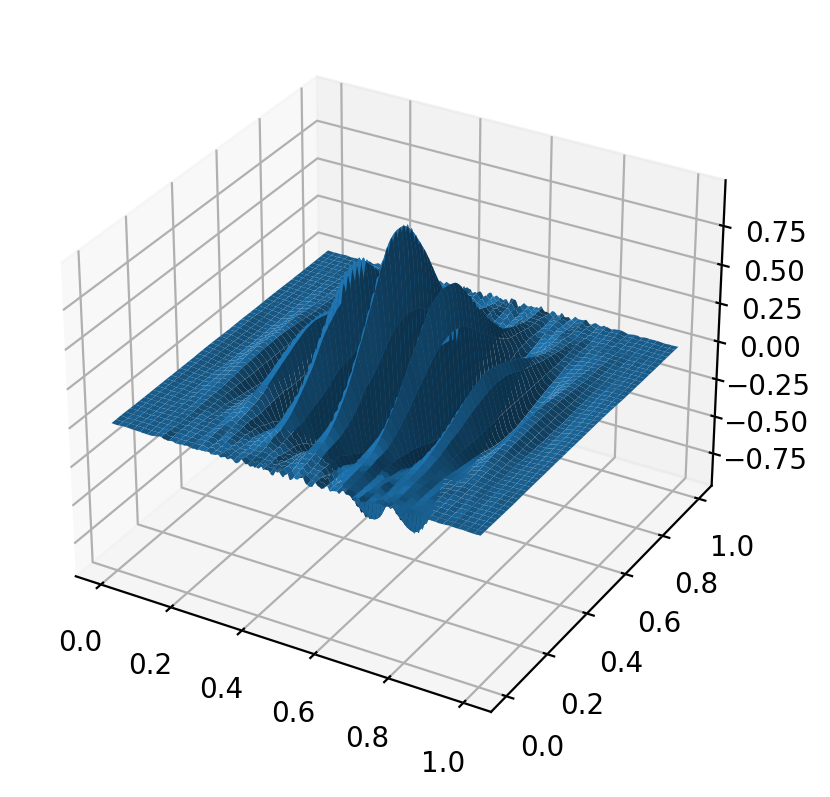

time taken:  5.992410898208618
neuron num 		 error 		 order
4		tensor(0.18740610)		*
8		tensor(0.18364403)		tensor(0.02925592)
16		tensor(0.17141281)		tensor(0.09943711)
32		tensor(0.12991172)		tensor(0.39994331)
64		tensor(0.08510471)		tensor(0.61022073)
128		tensor(0.02908147)		tensor(1.54913879)
256		tensor(0.01163332)		tensor(1.32183712)
512		tensor(0.00447573)		tensor(1.37806830)


In [27]:

def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

function_name = "gabor2d" 
filename_write = "data/2DQMCOGA-{}-order.txt".format(function_name)
f_write = open(filename_write, "a")
f_write.write("\n")
f_write.close() 

for N0 in [2*3,2**4,2**5,2**6,2**7]: 
    save = True 
    f_write = open(filename_write, "a")
    my_model = None 
    s = 2**3  
    Nx = 50 
    order = 3    
    exponent = 9  
    num_epochs = 2**exponent  
    plot_freq = num_epochs
    err_QMC2, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_OGA_2D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,s*N0)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_OGA_2D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,s*N0)
        torch.save(my_model,filename)

    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_QMC2[i] for i in neuron_nums ]
    f_write.write('dictionary size: {}\n'.format(s*N0))
    f_write.write("neuron num \t\t error \t\t order\n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
            f_write.write("{} \t\t {} \t\t * \n".format(neuron_nums[i],item))
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            f_write.write("{} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2)))
    f_write.write("\n")
    f_write.close()


### $\sin(\pi x_1) \sin(\pi x_2)$ 

In [13]:
## deterministic dictionary 
def target(x):
    return torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2]) 

save =False 
exponent = 8  
num_epochs= 2**exponent
plot_freq = 2**exponent+1 
Nx = 50 
order = 3 
err_list_deterministic = [] 
dictionary_size_deterministic = [[2**7,2**7]]
for N_list in dictionary_size_deterministic:  # 
    my_model = None 

    err, my_model = OGAL2FittingReLU2D(my_model,target,N_list,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "ls")


    err_list_deterministic.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))
if save:           
    torch.save(err_list_deterministic, "2Dsinx1sinx2_err_list_deterministic.pt")



using linear solver:  ls
epoch:  1	assembling the matrix time taken:  0.00022411346435546875
solving Ax = b time taken:  0.00017142295837402344
epoch:  2	assembling the matrix time taken:  0.00020933151245117188
solving Ax = b time taken:  0.00018906593322753906
epoch:  3	assembling the matrix time taken:  0.00019669532775878906
solving Ax = b time taken:  0.00019025802612304688
epoch:  4	assembling the matrix time taken:  0.00020170211791992188
solving Ax = b time taken:  0.00016617774963378906
epoch:  5	assembling the matrix time taken:  0.0002009868621826172
solving Ax = b time taken:  0.0001583099365234375
epoch:  6	assembling the matrix time taken:  0.0002009868621826172
solving Ax = b time taken:  0.00023436546325683594
epoch:  7	assembling the matrix time taken:  0.0001881122589111328
solving Ax = b time taken:  0.00016808509826660156
epoch:  8	assembling the matrix time taken:  0.0001919269561767578
solving Ax = b time taken:  0.0001709461212158203
epoch:  9	assembling the matr

epoch:  72	assembling the matrix time taken:  0.0002243518829345703
solving Ax = b time taken:  0.0009081363677978516
epoch:  73	assembling the matrix time taken:  0.0002396106719970703
solving Ax = b time taken:  0.0009374618530273438
epoch:  74	assembling the matrix time taken:  0.0002105236053466797
solving Ax = b time taken:  0.0009436607360839844
epoch:  75	assembling the matrix time taken:  0.00023102760314941406
solving Ax = b time taken:  0.0009624958038330078
epoch:  76	assembling the matrix time taken:  0.0002086162567138672
solving Ax = b time taken:  0.0021636486053466797
epoch:  77	assembling the matrix time taken:  0.00021123886108398438
solving Ax = b time taken:  0.0010135173797607422
epoch:  78	assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.0010099411010742188
epoch:  79	assembling the matrix time taken:  0.00021123886108398438
solving Ax = b time taken:  0.0010609626770019531
epoch:  80	assembling the matrix time taken:  0.0002

epoch:  144	assembling the matrix time taken:  0.0002372264862060547
solving Ax = b time taken:  0.0028257369995117188
epoch:  145	assembling the matrix time taken:  0.0002605915069580078
solving Ax = b time taken:  0.003005504608154297
epoch:  146	assembling the matrix time taken:  0.0002377033233642578
solving Ax = b time taken:  0.0030069351196289062
epoch:  147	assembling the matrix time taken:  0.0003025531768798828
solving Ax = b time taken:  0.0030145645141601562
epoch:  148	assembling the matrix time taken:  0.00023698806762695312
solving Ax = b time taken:  0.0030410289764404297
epoch:  149	assembling the matrix time taken:  0.00025725364685058594
solving Ax = b time taken:  0.0030889511108398438
epoch:  150	assembling the matrix time taken:  0.00026106834411621094
solving Ax = b time taken:  0.003063678741455078
epoch:  151	assembling the matrix time taken:  0.00025844573974609375
solving Ax = b time taken:  0.0032167434692382812
epoch:  152	assembling the matrix time taken: 

In [14]:
## random dictionary 
def target(x):
    return torch.sin(pi*x[:,0:1])*torch.sin(pi*x[:,1:2]) 

exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent +1
err_list_random = [] 

for s in [2**2]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
if save:  
    torch.save(err_list_random, "2Dsinx1sinx2_err_list_random.pt")



using linear solver:  direct
epoch:  1	assembling the matrix time taken:  0.00022602081298828125
solving Ax = b time taken:  0.00018334388732910156
epoch:  2	assembling the matrix time taken:  0.00020575523376464844
solving Ax = b time taken:  0.00014328956604003906
epoch:  3	assembling the matrix time taken:  0.00019311904907226562
solving Ax = b time taken:  0.0001342296600341797
epoch:  4	assembling the matrix time taken:  0.00018858909606933594
solving Ax = b time taken:  0.0001201629638671875
epoch:  5	assembling the matrix time taken:  0.00018978118896484375
solving Ax = b time taken:  0.00012350082397460938
epoch:  6	assembling the matrix time taken:  0.0001862049102783203
solving Ax = b time taken:  0.00011992454528808594
epoch:  7	assembling the matrix time taken:  0.000186920166015625
solving Ax = b time taken:  0.00013065338134765625
epoch:  8	assembling the matrix time taken:  0.00018906593322753906
solving Ax = b time taken:  0.00013303756713867188
epoch:  9	assembling the

solving Ax = b time taken:  0.0009405612945556641
epoch:  119	assembling the matrix time taken:  0.000213623046875
solving Ax = b time taken:  0.0009324550628662109
epoch:  120	assembling the matrix time taken:  0.00025177001953125
solving Ax = b time taken:  0.0008819103240966797
epoch:  121	assembling the matrix time taken:  0.00023293495178222656
solving Ax = b time taken:  0.0009298324584960938
epoch:  122	assembling the matrix time taken:  0.00023365020751953125
solving Ax = b time taken:  0.0009219646453857422
epoch:  123	assembling the matrix time taken:  0.0002484321594238281
solving Ax = b time taken:  0.0009207725524902344
epoch:  124	assembling the matrix time taken:  0.00022268295288085938
solving Ax = b time taken:  0.0009465217590332031
epoch:  125	assembling the matrix time taken:  0.0002567768096923828
solving Ax = b time taken:  0.0009272098541259766
epoch:  126	assembling the matrix time taken:  0.0002334117889404297
solving Ax = b time taken:  0.0009427070617675781
e

epoch:  192	assembling the matrix time taken:  0.0002505779266357422
solving Ax = b time taken:  0.0013852119445800781
epoch:  193	assembling the matrix time taken:  0.0002315044403076172
solving Ax = b time taken:  0.0016121864318847656
epoch:  194	assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.0016169548034667969
epoch:  195	assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.00162506103515625
epoch:  196	assembling the matrix time taken:  0.00026035308837890625
solving Ax = b time taken:  0.0015823841094970703
epoch:  197	assembling the matrix time taken:  0.00023221969604492188
solving Ax = b time taken:  0.0016450881958007812
epoch:  198	assembling the matrix time taken:  0.00025391578674316406
solving Ax = b time taken:  0.0016186237335205078
epoch:  199	assembling the matrix time taken:  0.0002536773681640625
solving Ax = b time taken:  0.0016286373138427734
epoch:  200	assembling the matrix time taken:

epoch:  275	assembling the matrix time taken:  0.00038361549377441406
solving Ax = b time taken:  0.002421855926513672
epoch:  276	assembling the matrix time taken:  0.0002353191375732422
solving Ax = b time taken:  0.0026006698608398438
epoch:  277	assembling the matrix time taken:  0.000255584716796875
solving Ax = b time taken:  0.0026047229766845703
epoch:  278	assembling the matrix time taken:  0.0002617835998535156
solving Ax = b time taken:  0.002600431442260742
epoch:  279	assembling the matrix time taken:  0.000274658203125
solving Ax = b time taken:  0.0026023387908935547
epoch:  280	assembling the matrix time taken:  0.00023436546325683594
solving Ax = b time taken:  0.002621173858642578
epoch:  281	assembling the matrix time taken:  0.00023317337036132812
solving Ax = b time taken:  0.002652406692504883
epoch:  282	assembling the matrix time taken:  0.00023603439331054688
solving Ax = b time taken:  0.0026531219482421875
epoch:  283	assembling the matrix time taken:  0.0002

epoch:  361	assembling the matrix time taken:  0.00025177001953125
solving Ax = b time taken:  0.0034685134887695312
epoch:  362	assembling the matrix time taken:  0.0002689361572265625
solving Ax = b time taken:  0.0034732818603515625
epoch:  363	assembling the matrix time taken:  0.0002551078796386719
solving Ax = b time taken:  0.0035033226013183594
epoch:  364	assembling the matrix time taken:  0.0002510547637939453
solving Ax = b time taken:  0.0034792423248291016
epoch:  365	assembling the matrix time taken:  0.0002562999725341797
solving Ax = b time taken:  0.0035228729248046875
epoch:  366	assembling the matrix time taken:  0.00023245811462402344
solving Ax = b time taken:  0.0035436153411865234
epoch:  367	assembling the matrix time taken:  0.00022912025451660156
solving Ax = b time taken:  0.0035440921783447266
epoch:  368	assembling the matrix time taken:  0.00023293495178222656
solving Ax = b time taken:  0.0035207271575927734
epoch:  369	assembling the matrix time taken:  

epoch:  432	assembling the matrix time taken:  0.0002694129943847656
solving Ax = b time taken:  0.004343748092651367
epoch:  433	assembling the matrix time taken:  0.0002541542053222656
solving Ax = b time taken:  0.004441738128662109
epoch:  434	assembling the matrix time taken:  0.0002334117889404297
solving Ax = b time taken:  0.004468202590942383
epoch:  435	assembling the matrix time taken:  0.0002434253692626953
solving Ax = b time taken:  0.00448298454284668
epoch:  436	assembling the matrix time taken:  0.00023293495178222656
solving Ax = b time taken:  0.004448413848876953
epoch:  437	assembling the matrix time taken:  0.00025963783264160156
solving Ax = b time taken:  0.004469633102416992
epoch:  438	assembling the matrix time taken:  0.00023412704467773438
solving Ax = b time taken:  0.004487276077270508
epoch:  439	assembling the matrix time taken:  0.00023412704467773438
solving Ax = b time taken:  0.0045053958892822266
epoch:  440	assembling the matrix time taken:  0.000

epoch:  509	assembling the matrix time taken:  0.0002162456512451172
solving Ax = b time taken:  0.005172252655029297
epoch:  510	assembling the matrix time taken:  0.00021266937255859375
solving Ax = b time taken:  0.00518345832824707
epoch:  511	assembling the matrix time taken:  0.00024628639221191406
solving Ax = b time taken:  0.005141496658325195
epoch:  512	assembling the matrix time taken:  0.00023126602172851562
solving Ax = b time taken:  0.005126476287841797
time taken:  4.103647470474243
neuron num 		 error 		 order
4		tensor(0.21070406)		*
8		tensor(0.04750096)		tensor(2.14918970)
16		tensor(0.02390981)		tensor(0.99035375)
32		tensor(0.00857184)		tensor(1.47992582)
64		tensor(0.00351887)		tensor(1.28449463)
128		tensor(0.00150699)		tensor(1.22344522)
256		tensor(0.00053882)		tensor(1.48377922)
512		tensor(0.00020985)		tensor(1.36042741)


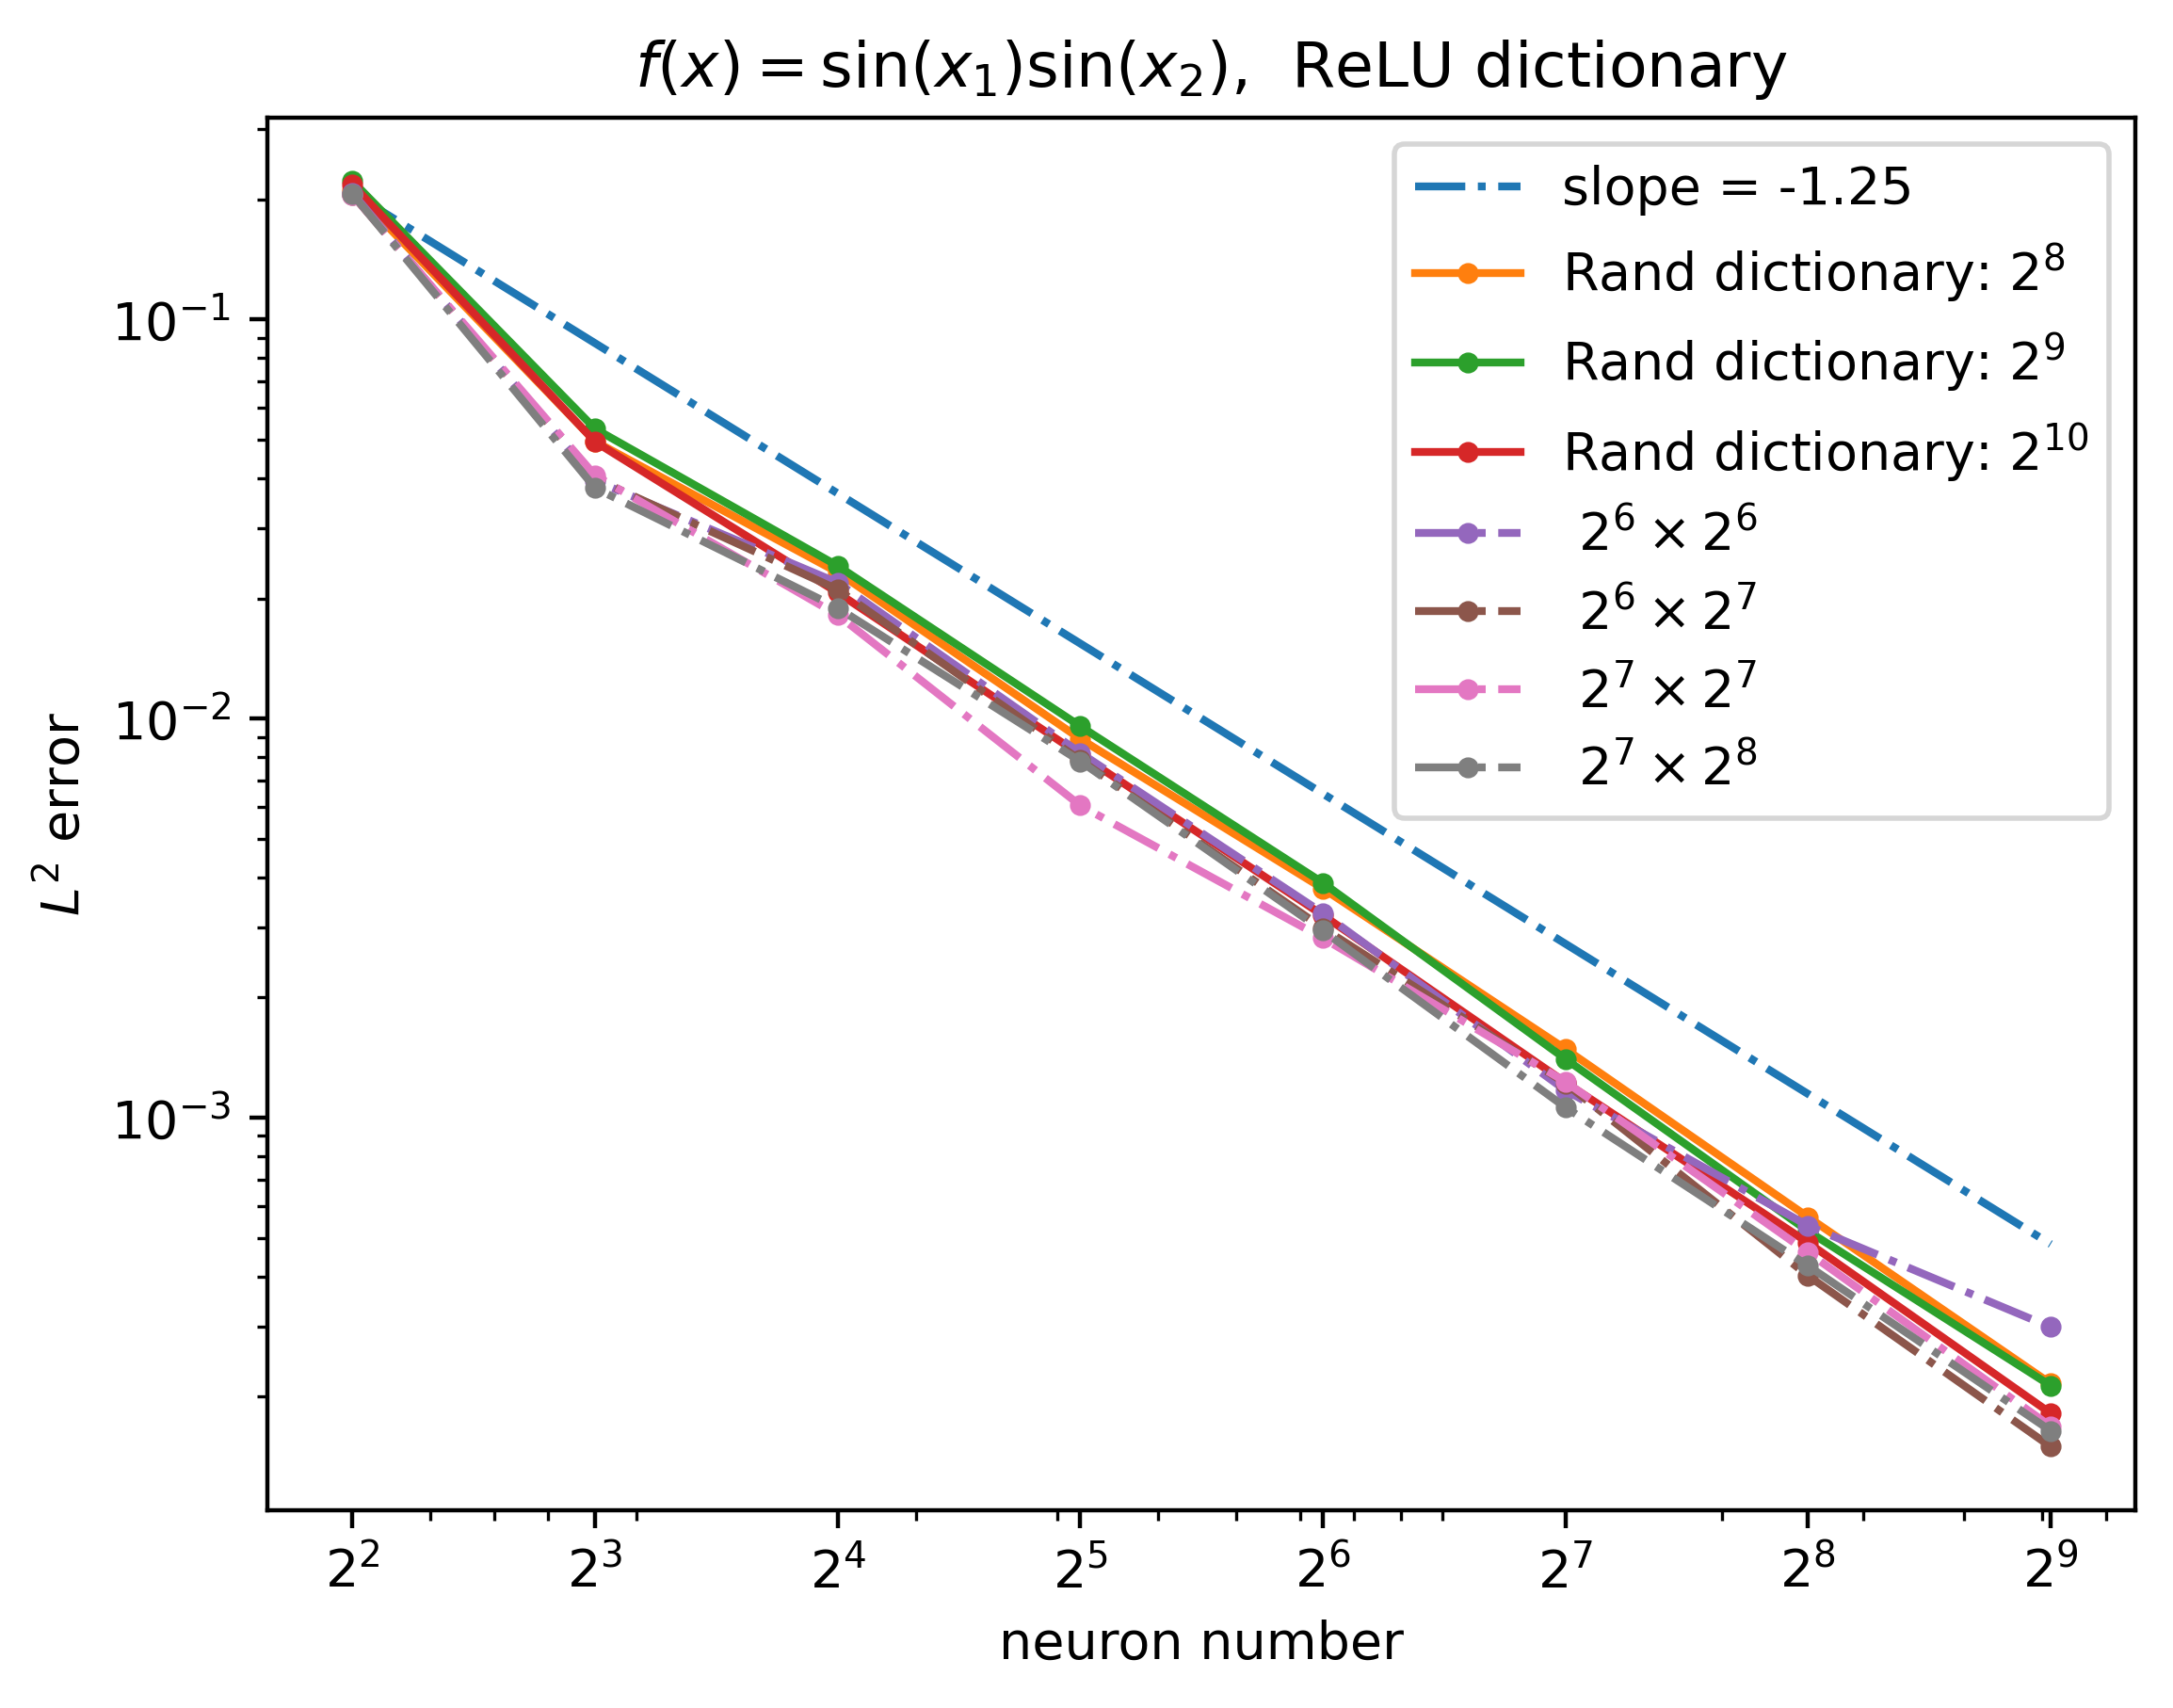

In [49]:
## plot results 

## read data: 
err_list_deterministic = torch.load("2Dsinx1sinx2_err_list_deterministic.pt")
err_list_random = torch.load("2Dsinx1sinx2_err_list_random.pt")

exponent = 9 
neuron_nums = np.array([2**j for j in range(2,exponent+1)]) 
dictionary_size_exponent_random = [8,9,10]
dictionary_size_random = [2**p for p in dictionary_size_exponent_random]
dictionary_size_deterministic = [[6,6],[6,7],[7,7],[7,8]]
plt.figure(dpi = 400)

x = np.array(range(4, 2**exponent+1))

ref = err_list_deterministic[0][2**2]* (x/ 4)**(-1.25)
plt.plot(x,ref,'-.',label = 'slope = -1.25')

for i, err in enumerate(err_list_random): 
    plt.plot(neuron_nums, err[neuron_nums],'.-',label = "Rand dictionary: $2^{{{}}}$".format(dictionary_size_exponent_random[i]))

for i, err in enumerate(err_list_deterministic): 
    plt.plot(neuron_nums, err[neuron_nums],'.-.', 
             label = " $2^{} \\times 2^{}$ ".format(dictionary_size_deterministic[i][0],dictionary_size_deterministic[i][1] ))
plt.title(" $f(x) = \sin(x_1)\sin(x_2)$,  ReLU dictionary")
plt.yscale('log')
plt.xscale('log')
# plt.grid("True")
plt.xlabel("neuron number")
plt.ylabel("$L^2$ error")
plt.xticks(neuron_nums,[rf"$2^{{{ns}}}$" for ns in range(2,exponent+1)])
plt.legend()    
plt.show()

### $\sin(4\pi x_1) \sin(8\pi x_2)$ 

In [41]:
def target(x):
    return torch.sin(4*pi*x[:,0:1])*torch.sin(8*pi*x[:,1:2]) 

## deterministic dictionary 
num_epochs= 2**exponent
plot_freq = 2**exponent+1
Nx = 50 
order = 3 
err_list_deterministic = [] 
dictionary_size_deterministic = [[6,6],[6,7],[7,7],[7,8]]
for num in dictionary_size_deterministic:  # 
    my_model = None 
    relu_dict_parameters = generate_relu_dict2D(2**num[0],2**num[1]).to(device)
    err, my_model = OGAL2FittingReLU2D(my_model,target,relu_dict_parameters,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")

    err_list_deterministic.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))
            
torch.save(err_list_deterministic, "2Dsin4x1sin8x2_err_list_deterministic.pt")

## random dictionary 

exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent+1 
err_list_random = [] 

for s in [2**2, 2**3,2**4]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            
torch.save(err_list_random, "2Dsin4x1sin8x2_err_list_random.pt")



using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	epoch:  90	epoch:  91	epoch:  

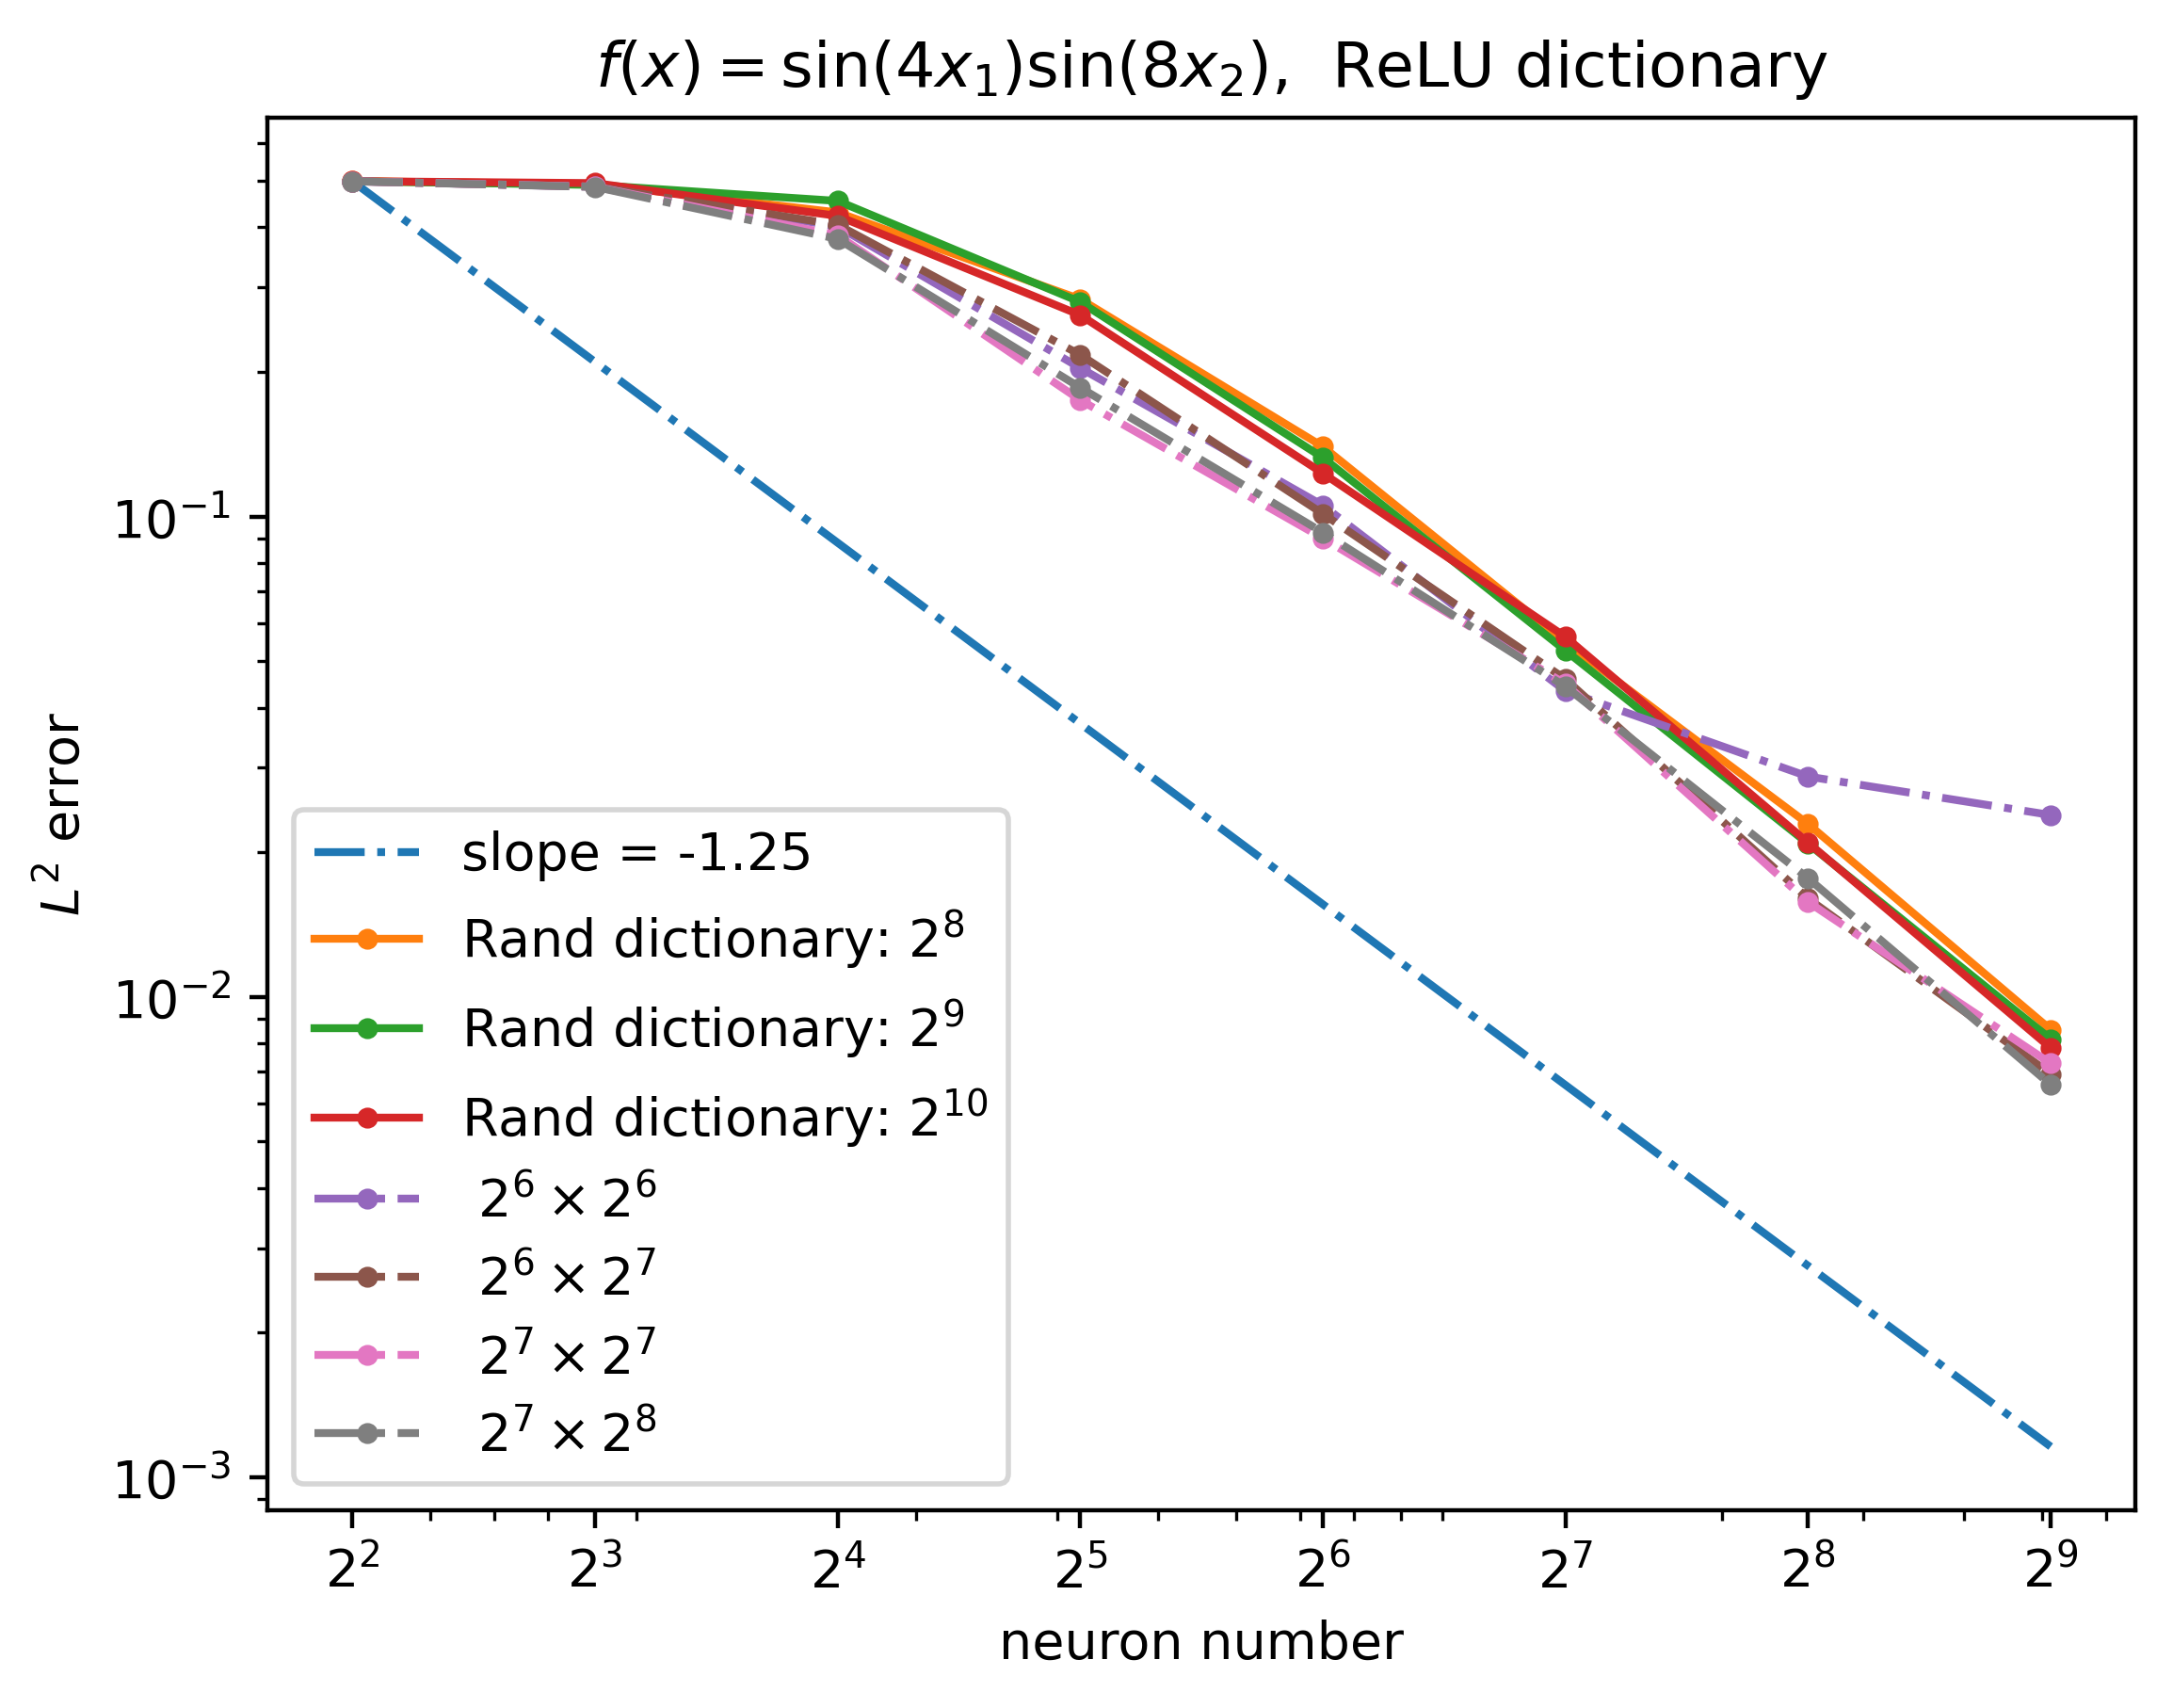

In [48]:
## plot results 

## read data: 
err_list_deterministic = torch.load("2Dsin4x1sin8x2_err_list_deterministic.pt")
err_list_random = torch.load("2Dsin4x1sin8x2_err_list_random.pt")

exponent = 9 
neuron_nums = np.array([2**j for j in range(2,exponent+1)]) 
dictionary_size_exponent_random = [8,9,10]
dictionary_size_random = [2**p for p in dictionary_size_exponent_random]
dictionary_size_deterministic = [[6,6],[6,7],[7,7],[7,8]]
plt.figure(dpi = 400)

x = np.array(range(4, 2**exponent+1))

ref = err_list_deterministic[0][2**2]* (x/ 4)**(-1.25)
plt.plot(x,ref,'-.',label = 'slope = -1.25')

for i, err in enumerate(err_list_random): 
    plt.plot(neuron_nums, err[neuron_nums],'.-',label = "Rand dictionary: $2^{{{}}}$".format(dictionary_size_exponent_random[i]))

for i, err in enumerate(err_list_deterministic): 
    plt.plot(neuron_nums, err[neuron_nums],'.-.', 
             label = " $2^{} \\times 2^{}$ ".format(dictionary_size_deterministic[i][0],dictionary_size_deterministic[i][1] ))
plt.title(" $f(x) = \sin(4x_1)\sin(8x_2)$,  ReLU dictionary")
plt.yscale('log')
plt.xscale('log')
# plt.grid("True")
plt.xlabel("neuron number")
plt.ylabel("$L^2$ error")
plt.xticks(neuron_nums,[rf"$2^{{{ns}}}$" for ns in range(2,exponent+1)])
plt.legend()    
plt.show()

### Gabor funciton 2D 

In [54]:
my_model = None 
def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent+1 
err_list_random = [] 

for s in [2**2, 2**3,2**4]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            
torch.save(err_list_random, "2DGabor_err_list_random.pt")


using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	epoch:  90	epoch:  91	epoch:  

In [12]:
neuron_nums = [2**j for j in range(2,10)]
err_list = [err[i] for i in neuron_nums ]

print("neuron num \t\t error \t\t order")
for i, item in enumerate(err_list):
    if i == 0: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t")
        print("*")
    else: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t") 
        print(np.log(err_list[i-1]/err_list[i])/np.log(2))
    

neuron num 		 error 		 order
4		tensor(0.18746856)		*
8		tensor(0.18456400)		tensor(0.02252749)
16		tensor(0.17304419)		tensor(0.09298067)
32		tensor(0.11998072)		tensor(0.52833792)
64		tensor(0.06591547)		tensor(0.86411360)
128		tensor(0.03074313)		tensor(1.10035282)
256		tensor(0.01140568)		tensor(1.43051166)
512		tensor(0.00441209)		tensor(1.37021872)


using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

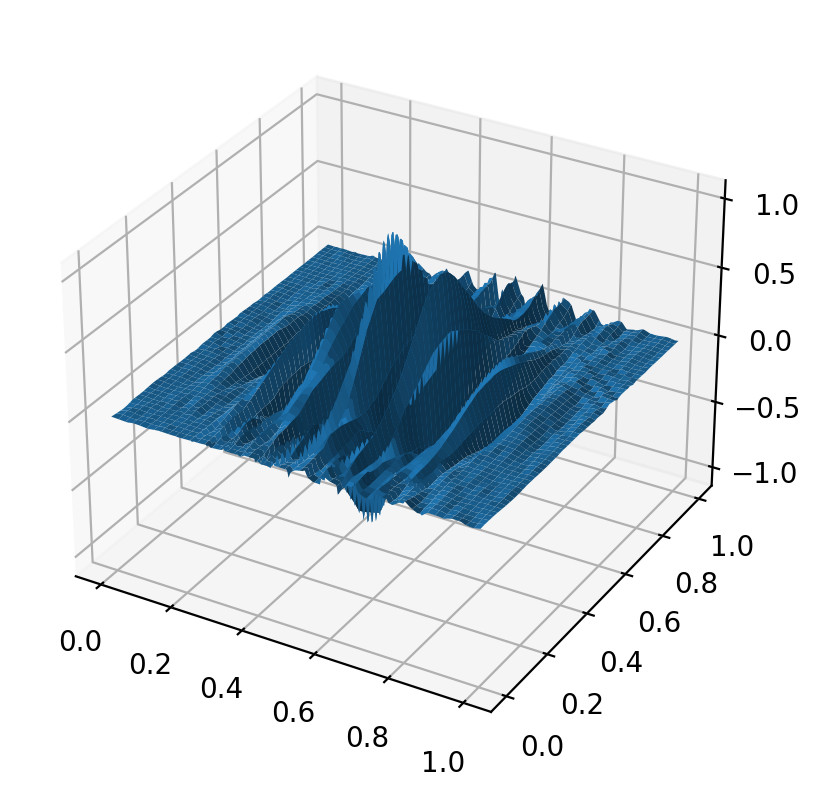

time taken:  50.13648271560669
neuron num 		 error 		 order
4		tensor(0.18676358)		*
8		tensor(0.17429207)		tensor(0.09970619)
16		tensor(0.13720771)		tensor(0.34514541)
32		tensor(0.11845465)		tensor(0.21202674)
64		tensor(0.06757468)		tensor(0.80978020)
128		tensor(0.05024533)		tensor(0.42749306)
256		tensor(0.04963082)		tensor(0.01775325)
512		tensor(0.04958918)		tensor(0.00121091)
using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  5

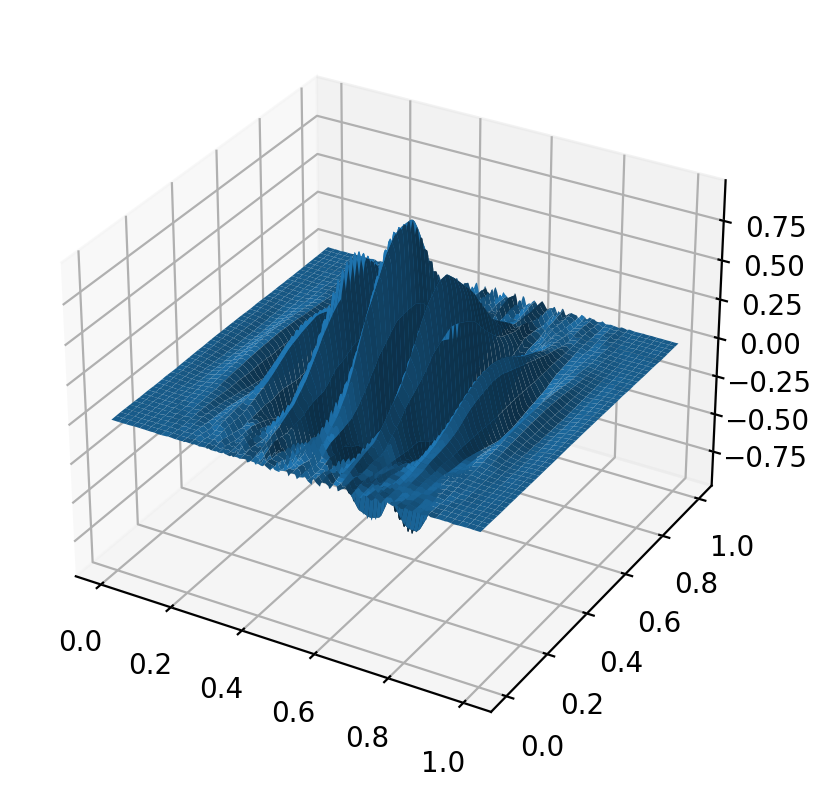

time taken:  54.75861167907715
neuron num 		 error 		 order
4		tensor(0.18593198)		*
8		tensor(0.16280500)		tensor(0.19163000)
16		tensor(0.13869569)		tensor(0.23122206)
32		tensor(0.10418308)		tensor(0.41280190)
64		tensor(0.06649248)		tensor(0.64785793)
128		tensor(0.02379158)		tensor(1.48273990)
256		tensor(0.01028773)		tensor(1.20952620)
512		tensor(0.00936732)		tensor(0.13521620)
using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  5

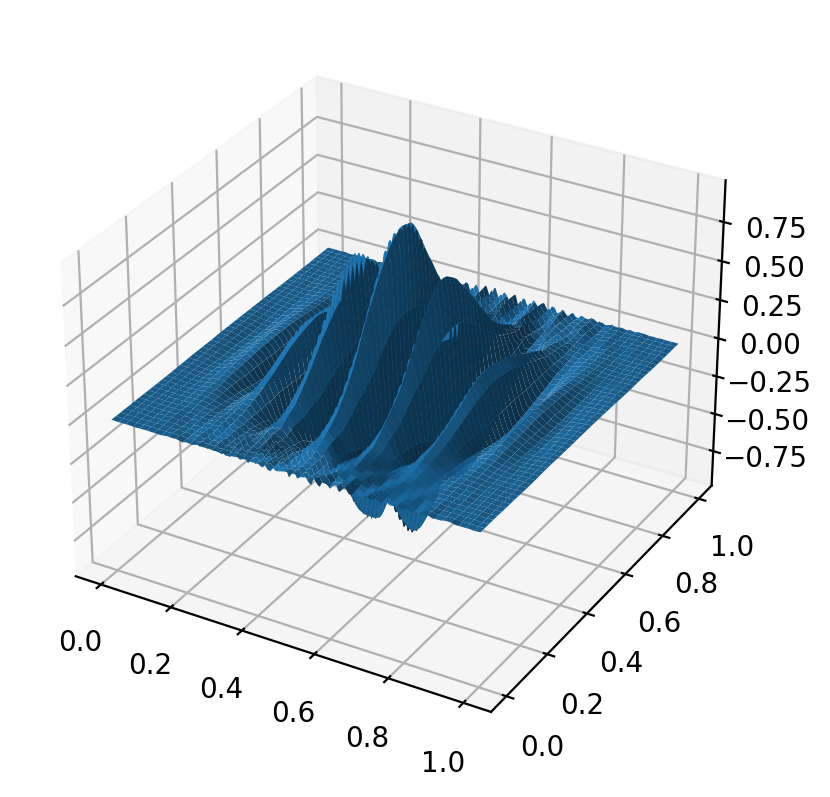

time taken:  62.14431357383728
neuron num 		 error 		 order
4		tensor(0.18593198)		*
8		tensor(0.16281163)		tensor(0.19157120)
16		tensor(0.15241313)		tensor(0.09521660)
32		tensor(0.12363460)		tensor(0.30190463)
64		tensor(0.06885179)		tensor(0.84451640)
128		tensor(0.02471193)		tensor(1.47828664)
256		tensor(0.01077886)		tensor(1.19700235)
512		tensor(0.00666565)		tensor(0.69338874)
using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  5

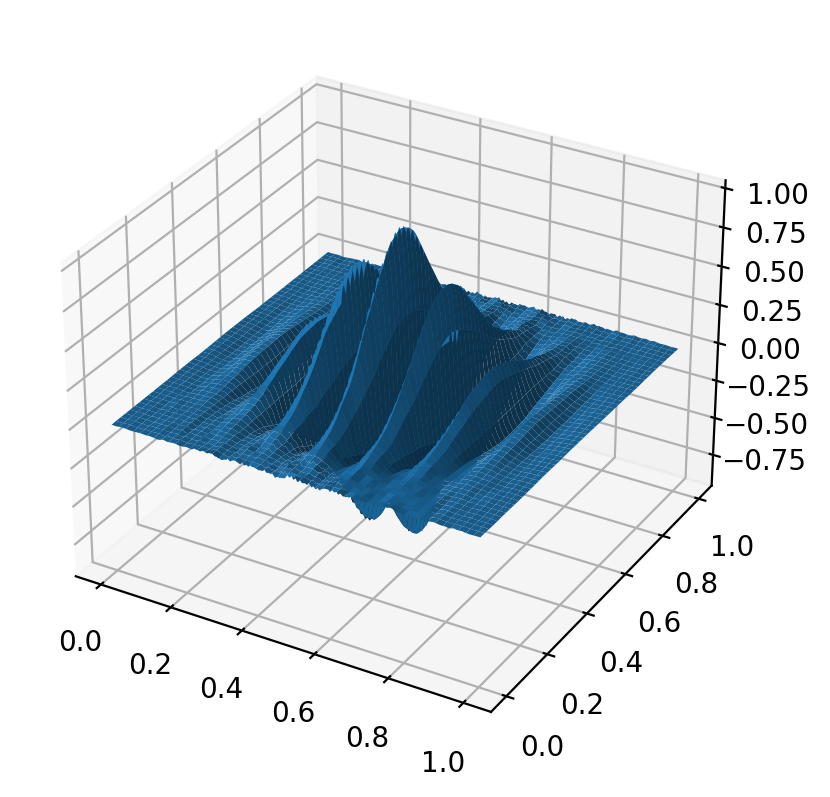

time taken:  79.55192923545837
neuron num 		 error 		 order
4		tensor(0.18754367)		*
8		tensor(0.16451488)		tensor(0.18900847)
16		tensor(0.14522769)		tensor(0.17990156)
32		tensor(0.12550798)		tensor(0.21053739)
64		tensor(0.05945584)		tensor(1.07788877)
128		tensor(0.02393172)		tensor(1.31289431)
256		tensor(0.00964766)		tensor(1.31067290)
512		tensor(0.00295331)		tensor(1.70784698)


In [12]:


def target(x):
    sigma = 0.15# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2)) *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

exponent = 9 
num_epochs= 2**exponent
plot_freq = 2**exponent
Nx = 50 
order = 3 
err_list = [] 
for num in [[6,6],[6,7],[7,7],[7,8]]:  # 
    my_model = None 
    relu_dict_parameters = generate_relu_dict2D(2**num[0],2**num[1]).to(device)
    err, my_model = OGAL2FittingReLU2D(my_model,target,relu_dict_parameters,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")

    err_list.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))


In [13]:
# torch.save(err_list, "2DGabor_err_list.pt")

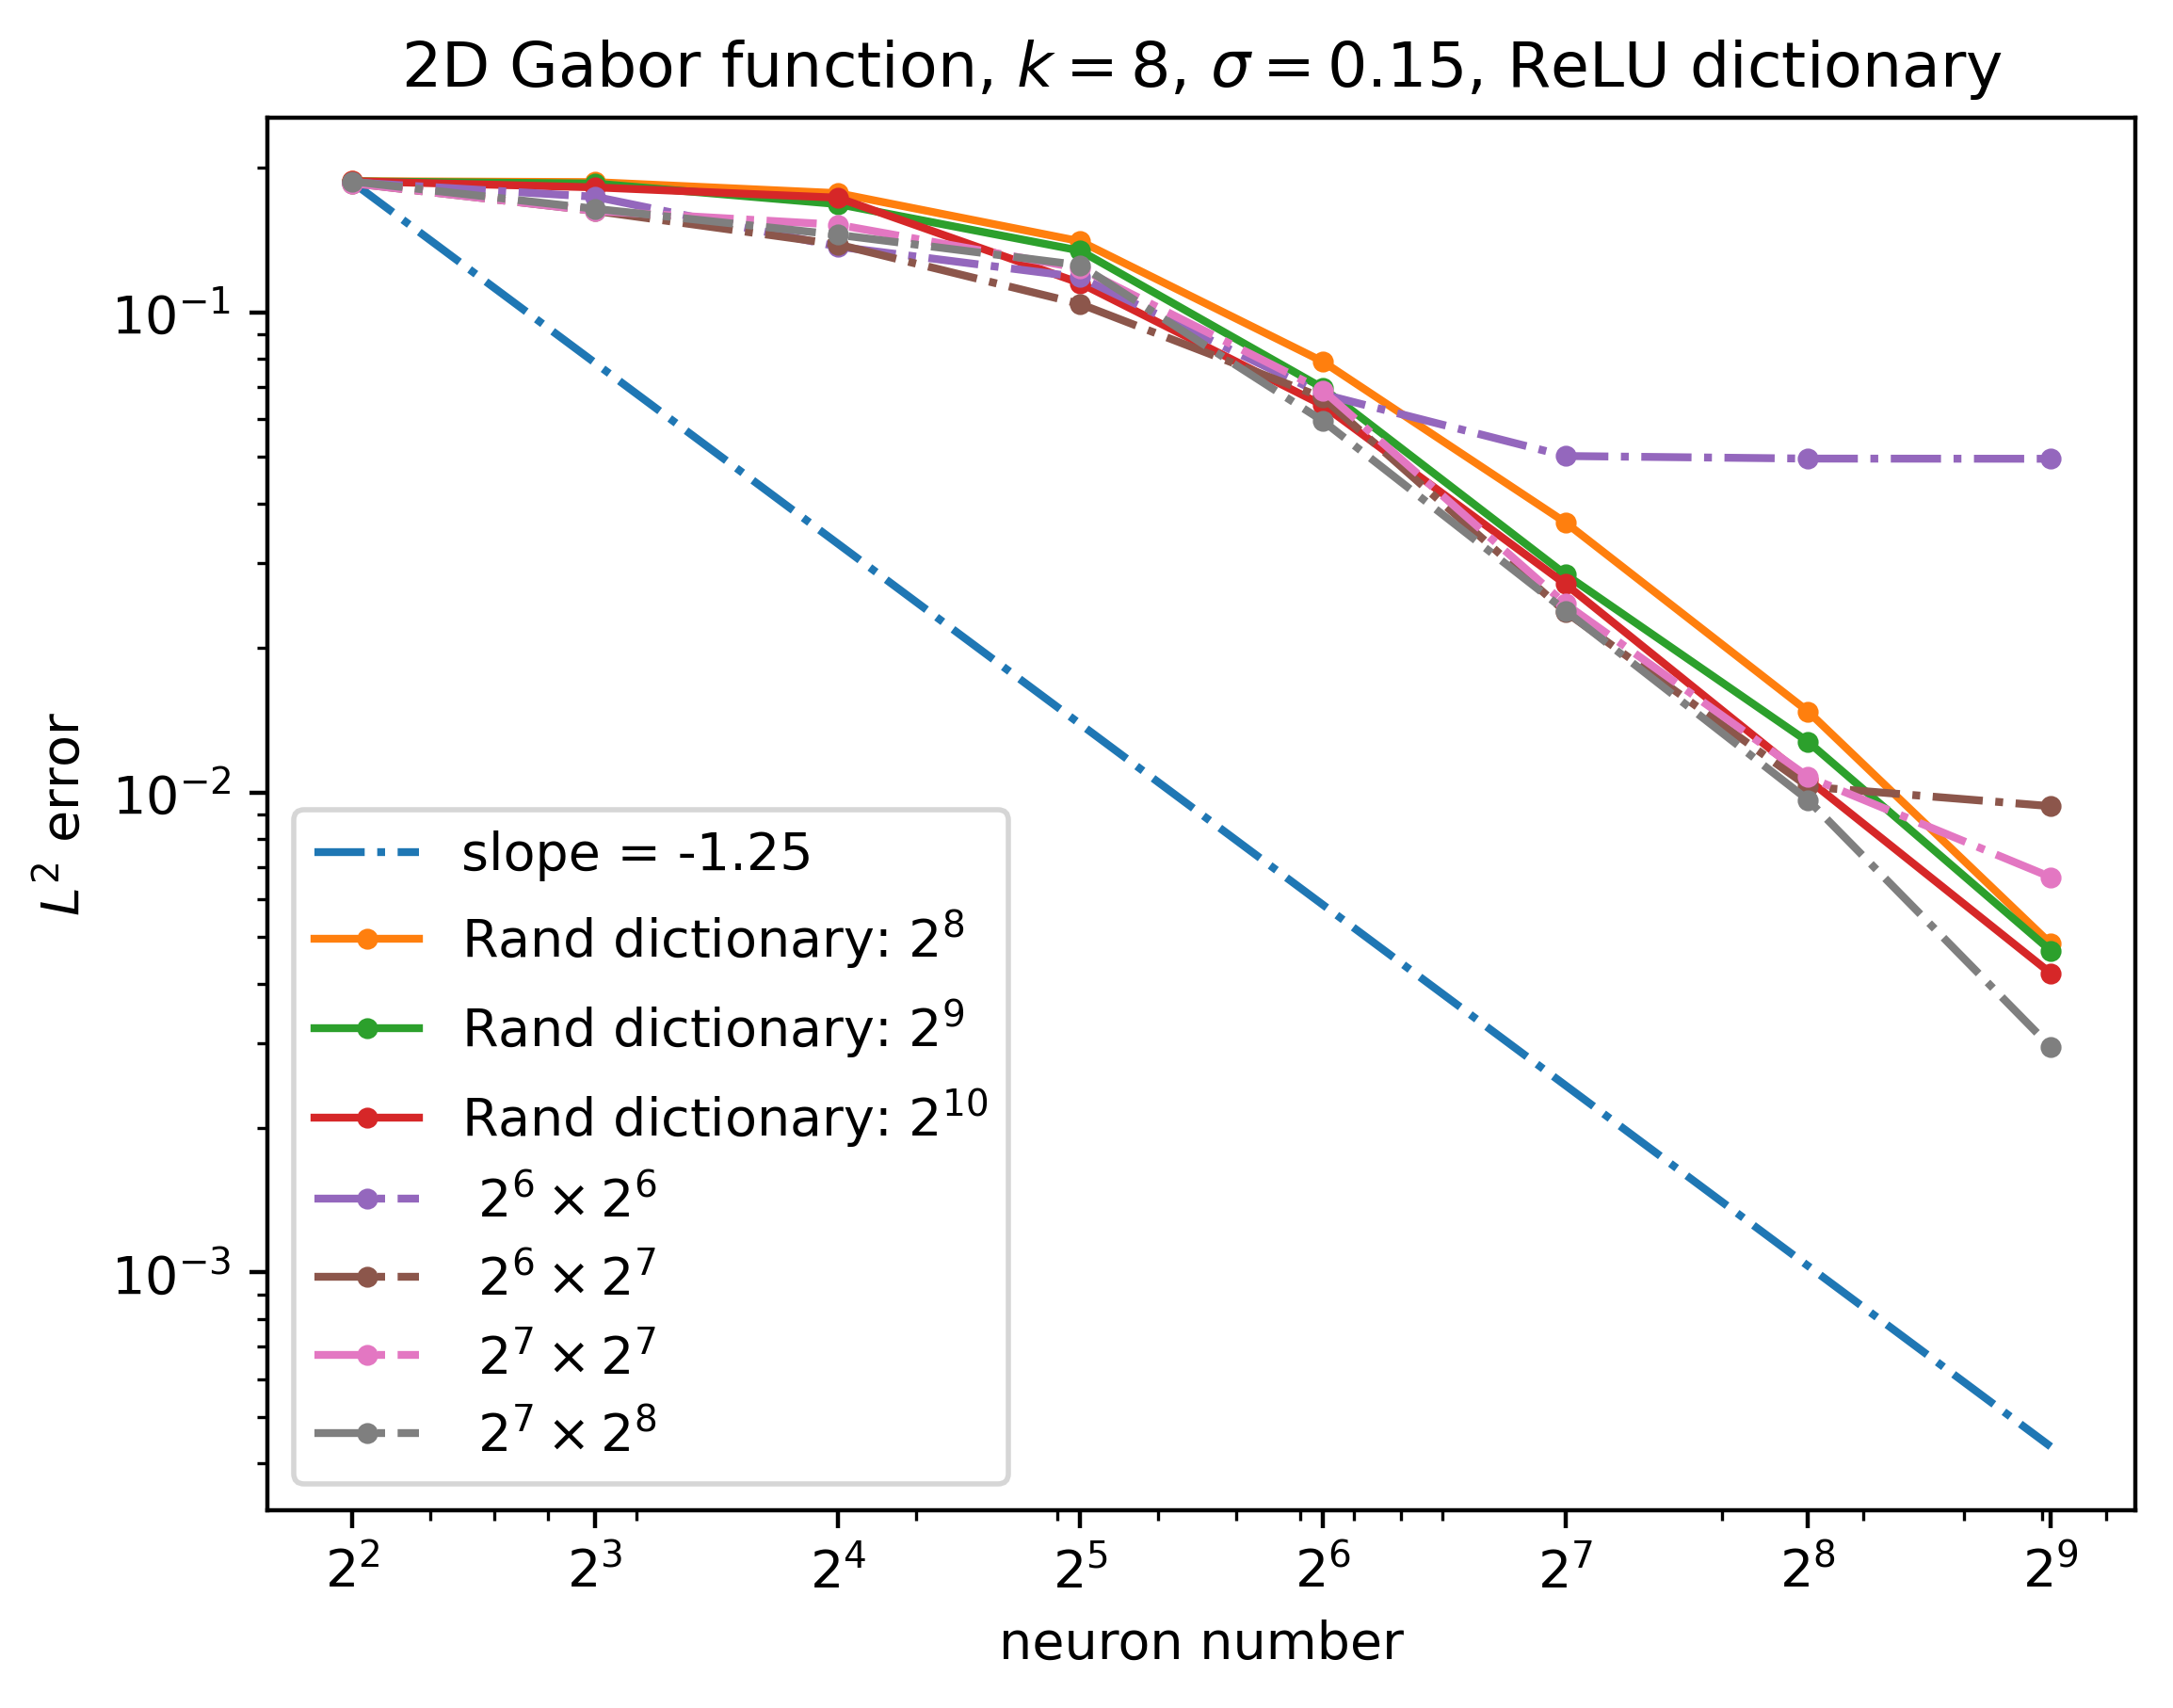

In [56]:
err_list_deterministic = torch.load("2DGabor_err_list_deterministic.pt")


exponent = 9 
neuron_nums = np.array([2**j for j in range(2,exponent+1)]) 
err_qmc = [0.18798549,0.18514664,0.17453844 ,0.12222007,0.07127362,0.03076002,0.01082704,0.00424251] 

dictionary_size_exponent_random = [8,9,10]
dictionary_size = [[6,6],[6,7],[7,7],[7,8]]
plt.figure(dpi = 400)

x = np.array(range(4, 2**exponent+1))

ref = err_list_deterministic[0][2**2]* (x/ 4)**(-1.25)
plt.plot(x,ref,'-.',label = 'slope = -1.25')

for i, err in enumerate(err_list_random): 
    plt.plot(neuron_nums, err[neuron_nums],'.-',label = "Rand dictionary: $2^{{{}}}$".format(dictionary_size_exponent_random[i]))

# plt.plot(neuron_nums, err_qmc,'.-',label = "Rand dictionary: $2^{10}$")

for i, err in enumerate(err_list_deterministic): 
    plt.plot(neuron_nums, err[neuron_nums],'.-.', 
             label = " $2^{} \\times 2^{}$ ".format(dictionary_size[i][0],dictionary_size[i][1] ))
plt.title("2D Gabor function, $k = 8$, $\sigma=0.15$, ReLU dictionary")
plt.yscale('log')
plt.xscale('log')
# plt.grid("True")
plt.xlabel("neuron number")
plt.ylabel("$L^2$ error")
plt.xticks(neuron_nums,[rf"$2^{{{ns}}}$" for ns in range(2,10)])
plt.legend()    
plt.show()

### Gaussian function 2D 

In [6]:
my_model = None 
def target(x):
    sigma = 0.1# s.d of Gaussian 
    frequency = 8  # frequency of cosine 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2))  # *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

function_name = "2DGaussian"
# plot_2D(target)
exponent = 9 
num_epochs=  2**exponent 
plot_freq = 2**exponent+1 
err_list_random = [] 

for s in [2**2, 2**3,2**4]: 
    my_model = None 
    N0 = 2**6 
    Nx = 50 
    order = 3 
    err, my_model = OGAL2FittingReLU2D_QMC(my_model,target,s,N0,num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")
    err_list_random.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err[i] for i in neuron_nums ]
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            
torch.save(err_list_random, "2D_{}_err_list_random.pt".format(function_name))


using linear solver:  direct
epoch:  1	epoch:  2	epoch:  3	epoch:  4	epoch:  5	epoch:  6	epoch:  7	epoch:  8	epoch:  9	epoch:  10	epoch:  11	epoch:  12	epoch:  13	epoch:  14	epoch:  15	epoch:  16	epoch:  17	epoch:  18	epoch:  19	epoch:  20	epoch:  21	epoch:  22	epoch:  23	epoch:  24	epoch:  25	epoch:  26	epoch:  27	epoch:  28	epoch:  29	epoch:  30	epoch:  31	epoch:  32	epoch:  33	epoch:  34	epoch:  35	epoch:  36	epoch:  37	epoch:  38	epoch:  39	epoch:  40	epoch:  41	epoch:  42	epoch:  43	epoch:  44	epoch:  45	epoch:  46	epoch:  47	epoch:  48	epoch:  49	epoch:  50	epoch:  51	epoch:  52	epoch:  53	epoch:  54	epoch:  55	epoch:  56	epoch:  57	epoch:  58	epoch:  59	epoch:  60	epoch:  61	epoch:  62	epoch:  63	epoch:  64	epoch:  65	epoch:  66	epoch:  67	epoch:  68	epoch:  69	epoch:  70	epoch:  71	epoch:  72	epoch:  73	epoch:  74	epoch:  75	epoch:  76	epoch:  77	epoch:  78	epoch:  79	epoch:  80	epoch:  81	epoch:  82	epoch:  83	epoch:  84	epoch:  85	epoch:  86	epoch:  87	epoch:  88	epoch:  89	e

In [ ]:

function_name = "2DGaussian"

def target(x):
    sigma = 0.1# s.d of Gaussian 
    z=  torch.exp( - ( (x[:,0:1]-0.5)**2 + ( x[:,1:2] -0.5)**2)  / (2*sigma**2))  # *  torch.cos(2 * pi * frequency * x[:,0:1])
    return z 

exponent = 9 
num_epochs= 2**exponent
plot_freq = 2**exponent
Nx = 50 
order = 3 
err_list = [] 
for num in [[6,6],[6,7],[7,7],[7,8]]:  # 
    my_model = None 
    err, my_model = OGAL2FittingReLU2D(my_model,target,N_list,
                            num_epochs,plot_freq, Nx, order, k =1, linear_solver = "direct")

    err_list_deterministic.append(err)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    errs = [err[i] for i in neuron_nums ]
    
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(errs):
        if i == 0: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t")
            print("*")
        else: 
            print(neuron_nums[i], end = "\t\t")
            print(item, end = "\t\t") 
            print(np.log(errs[i-1]/errs[i])/np.log(2))

torch.save(err_list_deterministic, "2D_{}_err_list_deterministic.pt".format(function_name))


In [20]:
import os
import json

cuda_alloc_conf = os.environ.get('PYTORCH_CUDA_ALLOC_CONF')
if cuda_alloc_conf:
    cuda_alloc_conf = json.loads(cuda_alloc_conf)
    max_split_size_mb = cuda_alloc_conf.get('max_split_size_mb')
    print(f"Current max_split_size_mb: {max_split_size_mb} MB")
else:
    print("PYTORCH_CUDA_ALLOC_CONF environment variable not set.")

Current max_split_size_mb: 2048 MB


In [7]:
neuron_nums = [2**j for j in range(2,9)]
err_list = [err[i] for i in neuron_nums ]

print("neuron num \t\t error \t\t order")
for i, item in enumerate(err_list):
    if i == 0: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t")
        print("*")
    else: 
        print(neuron_nums[i], end = "\t\t")
        print(item, end = "\t\t") 
        print(np.log(err_list[i-1]/err_list[i])/np.log(2))

neuron num 		 error 		 order
4		tensor(0.18657228)		*
8		tensor(0.16087906)		tensor(0.21375813)
16		tensor(0.13855207)		tensor(0.21554824)
32		tensor(0.12435550)		tensor(0.15595799)
64		tensor(0.06713362)		tensor(0.88936288)
128		tensor(0.02542356)		tensor(1.40086969)
256		tensor(0.01910289)		tensor(0.41237462)


In [7]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Print the CUDA version
    print(f"CUDA version: {torch.version.cuda}")
else:
    print("CUDA is not available on this system.")

CUDA version: 11.7


In [2]:
import subprocess

# Run the 'nvidia-smi' command and capture the output
result = subprocess.run(['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE, text=True)

# Get the GPU memory total from the output
gpu_memory = int(result.stdout.strip())

# Print the GPU memory in gigabytes (GB)
print(f"GPU memory: {gpu_memory} MB")

GPU memory: 32768 MB


In [9]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the name of the GPU device
    gpu_name = torch.cuda.get_device_name(0)  # Assuming you have one GPU (device index 0)

    # Check if the GPU is an A100
    is_a100 = "A100" in gpu_name

    if is_a100:
        print(f"The GPU is an A100: {gpu_name}")
    else:
        print(f"The GPU is not an A100: {gpu_name}")
else:
    print("CUDA is not available on this system.")


The GPU is not an A100: NVIDIA GeForce GTX 1080 Ti
